In [1]:
from os import system as bash
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import TimestampType
from datetime import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
import pickle
import time
import os

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
splice = PySpliceContext(spark)

In [3]:
mmsi_freq = pd.read_pickle('Processed_Data/mmsi_freq.pkl')

In [4]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

def load_data(filename):
    a_file = open(filename, "rb")
    output = pickle.load(a_file)
    a_file.close()
    
    return output

def save_data(filename, data):
    a_file = open(filename, "wb")
    pickle.dump(data, a_file)
    a_file.close()

In [5]:
def get_location(my_df):
    my_df = my_df.sort_values(by=['BASEDATETIME'])
    
    datelist = list(my_df['BASEDATETIME'])
    
    #Getting datetime objects 
    datetime_objects = []
    for date in datelist:
        datetime_objects.append(datetime.strptime(date, '%Y-%m-%dT%X'))
        
    #Get latitude, longitude
    latitude = list(my_df['LAT'])
    longitude = list(my_df['LON'])
    latitude = np.array([float(lat) for lat in latitude])
    longitude = np.array([float(long) for long in longitude])
    
    #location: Store the 2d tuple of (latitude, longitude) for clustering
    location = []
    for i in range(len(latitude)):
        location.append([latitude[i], longitude[i]])

    location = np.array(location)

    return latitude, longitude, location, datetime_objects
    

In [6]:
def do_DBSCAN(location, min_samples = 20):
    clustering = DBSCAN(eps=0.0001, min_samples=min_samples).fit(location)

    labels = clustering.labels_

    '''#Print number of cluster
    print('Number of clusters:', len(set(list(labels))))
    print('Number of core points:', len(clustering.components_))
    print('Number of Noise Points:', np.sum(labels == -1))
    
    print('Printing size of each label:')
    for label in np.unique(labels):
        print(label , ':', np.sum(labels == label), end = '; ')'''
        
    return labels

In [7]:
def max_pool(indices, filter_size = 5):
    '''
    CONSTRAINTS:
        INDICES: Input should be a BOOLEAN numpy array of 1 dimension. BOOLEAN IS A REQUIREMENT. CODE LOGIC IS BASED ON THAT.
        FILTER_SIZE: Should be an odd number
    '''
    N = indices.shape[0]
    #Pad the array
    indices = np.pad(indices, filter_size//2, 'constant', constant_values=0)
    
    coarse = []
    for i in range(N):
        if np.sum( indices[i:i+filter_size] ) > filter_size//2:
            coarse.append(True)
        else:
            coarse.append(False)
            
    indices = np.array(coarse)
    return indices
    

In [8]:
def find_paths(labels, datetime_objects, latitude, longitude, filter_size = 5):
    #This means that all journey's of 3 hours or more will be taken into account in the dataset. This is a hyperparameter
    threshold_time = 1
    
    indices = labels == -1 #for pooling
    
    #Do max pooling
    indices = max_pool(indices, filter_size = filter_size)
    
    temp = np.diff(indices)
    chunks = np.where(temp == True)[0] # tells starting and end of a sequence
    print('Number of total paths found:', chunks.shape[0])

    paths = []
    path_lengths = []
    path_time = []
    for i in range(0, len(chunks), 2):
        start_index = chunks[i] + 1

        if i != len(chunks) - 1:
            end_index = chunks[i+1]
        else:
            end_index = len(labels) - 1

        #checking for very small paths of length less than 10
        path_len = end_index - start_index
        if path_len > 10:
            #Correcting the start and end index due to max pooling
            start_index = chunks[i] + 1 + filter_size // 2
            if end_index != len(labels) -1:
                end_index = chunks[i+1] - filter_size //2
            
            journey_time = (datetime_objects[end_index] - datetime_objects[start_index]).seconds/3600
            #if journey_time > threshold_time:
            paths.append([start_index, end_index])
            path_lengths.append(end_index-start_index)
            path_time.append(journey_time)
    
    return paths, path_lengths, path_time

In [9]:
def plot_trajectory(mmsi, i, lat, long, journey_time):
    lat_diff = np.sum(np.abs(np.diff(lat)))
    long_diff = np.sum(np.abs(np.diff(long)))
    path_len_distance = lat_diff + long_diff
    speed_ratio = path_len_distance/journey_time
    flag = True
    
    if speed_ratio < 0.02 or path_len_distance < 0.1:
        print( mmsi + '_' + str(i), str(path_len_distance) + ' -- ' + str(speed_ratio) + ' -- ' + str(lat.shape[0])  )

        plt.plot(lat, long)
        plt.title(str(path_len_distance) + ' -- ' + str(speed_ratio) + ' -- ' + str(lat.shape[0]) )
        plt.savefig('Processed_Data/NewPlots/' + mmsi + '/' + str(i) + '.png')
        plt.close()
        
        flag = False
        
    return flag
        

In [10]:
def save_trajectors(mmsi, paths, path_time, latitude, longitude, datetime_objects):
    print(mmsi)
    try:
        os.mkdir('Processed_Data/NewPlots/' + mmsi)
    except:
        pass
    trajectories = []
    n_saved = 0
    
    for i, path in enumerate(paths):
        flag = plot_trajectory(mmsi, i, latitude[path[0]: path[1] + 1], longitude[path[0]: path[1] + 1], path_time[i])
        if flag:
            n_saved += 1
            trajectories.append([latitude[path[0]: path[1] + 1], longitude[path[0]: path[1] + 1], datetime_objects[path[0]: path[1] + 1]])
                
    data = [mmsi, trajectories]
    save_data('Processed_Data/NewDump/' + mmsi + '.pkl', data)
    
    return n_saved

In [11]:
SCHEMA = 'AGUPTA'
TABLE = 'january'

In [ ]:
counter = 0
#initialize done_mmsi, valid_mmsi
try:
    done_mmsi = np.load('done_mmsi.npy')
except:
    done_mmsi = np.array([])

    
total_trajectories_saved = 0
for mmsi in mmsi_freq[mmsi_freq.c1 > 20000].c0:
        
    if mmsi in done_mmsi:
        continue
    start = time.time()
    counter += 1
    print('Loading data from cluster', counter, mmsi, mmsi_freq[mmsi_freq.c0 == mmsi].c1)

    #Load data for particular MMSI and store locally
    query = 'select BaseDateTime, Lon, Lat from ' + SCHEMA + '.' + TABLE + ' where MMSI = ' + mmsi
    df = splice.df(query)
    local_df = df.toPandas()
    print('Finished Loading')
    
    #Get latitude, longitude, location and datetime_objects
    latitude, longitude, location, datetime_objects = get_location(local_df)

    #Do DBSCAN 
    labels = do_DBSCAN(location, min_samples = 10)
    
    #Find paths
    paths, path_lengths, path_time = find_paths(labels, datetime_objects, latitude, longitude,)
    print('Number of suggested paths:', len(paths))

    #Save trajectories
    n_saved = save_trajectors(mmsi, paths, path_time, latitude, longitude, datetime_objects)
    total_trajectories_saved += n_saved
    
    #Time and Save Done
    done_mmsi = np.array(list(done_mmsi) + [mmsi])
    np.save('done_mmsi.npy', done_mmsi)
    print('Number of trajectories saved:', n_saved)
    print('Total trajectories saved:', total_trajectories_saved)
    print('Length of done mmsi:', done_mmsi.shape)
    print('Time:', (time.time() - start)/60, '\n')
    
    
    

Loading data from cluster 1 366984000 7367    29881
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 2
Number of suggested paths: 1
366984000
366984000_0 0.00944000000001921 -- 0.025513513513565435 -- 12
Number of trajectories saved: 0
Total trajectories saved: 0
Length of done mmsi: (1001,)
Time: 2.9294185916582745 

Loading data from cluster 2 366978720 7368    37164
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 24
Number of suggested paths: 8
366978720
366978720_2 0.03197000000002248 -- 0.05997498697242363 -- 30
366978720_3 0.06264999999999787 -- 0.19578124999999336 -- 19
366978720_4 0.039950000000018804 -- 0.07371604305487836 -- 30
366978720_5 0.09428000000001902 -- 0.1343126236644513 -- 41
Number of trajectories saved: 4
Total trajectories saved: 4
Length of done mmsi: (1002,)
Time: 2.721348536014557 

Loading data from cluster 3 338051951 7372    24818
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 0
Number of sugge

366997630_107 0.0002799999999858471 -- 0.0019764705881353917 -- 9
366997630_108 0.006129999999885172 -- 0.0009896407910483258 -- 198
366997630_109 0.010230000000060357 -- 0.000977129211998336 -- 350
366997630_110 0.018609999999661397 -- 0.0008175029285286636 -- 695
366997630_111 0.00011999999998479893 -- 0.0003226288274423272 -- 10
366997630_112 0.0011799999999624333 -- 0.0023353490928338426 -- 19
366997630_113 0.01768999999952925 -- 0.0011378644939662897 -- 484
366997630_114 0.010950000000352844 -- 0.001162111966076184 -- 282
366997630_115 0.004229999999896705 -- 0.0014419089101058743 -- 97
366997630_116 0.022189999999600474 -- 0.0010648076564016115 -- 622
366997630_117 0.010140000000049554 -- 0.0009398074249569639 -- 309
Number of trajectories saved: 0
Total trajectories saved: 4
Length of done mmsi: (1004,)
Time: 2.749726072947184 

Loading data from cluster 5 367121040 7380    28692
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 4
Number of suggested paths: 1


366637150_7 0.041129999999967026 -- 0.12797579948131485 -- 13
366637150_8 0.02990999999998678 -- 0.06638471023424933 -- 19
366637150_9 0.016140000000000043 -- 0.0667862068965519 -- 11
Number of trajectories saved: 0
Total trajectories saved: 218
Length of done mmsi: (1008,)
Time: 2.639225701491038 

Loading data from cluster 9 367426920 7389    23373
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 115
Number of suggested paths: 55
367426920
367426920_0 0.0008100000000403895 -- 0.0012965762561784804 -- 21
367426920_1 0.008170000000497168 -- 0.0016167546175126322 -- 234
367426920_2 0.012539999999706453 -- 0.0015929990472120833 -- 359
367426920_3 0.022830000000613637 -- 0.0014441496371915639 -- 693
367426920_4 0.0023899999999876798 -- 0.0012763684913151827 -- 65
367426920_5 0.002130000000043708 -- 0.0010696052448259659 -- 69
367426920_6 0.0010800000000443788 -- 0.0011746223565437352 -- 32
367426920_7 0.0017000000000848559 -- 0.001332462442914322 -- 45
367426920_8 0.01

Number of trajectories saved: 38
Total trajectories saved: 313
Length of done mmsi: (1011,)
Time: 2.510027809937795 

Loading data from cluster 12 366993550 7486    27639
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 165
Number of suggested paths: 48
366993550
366993550_2 0.03270000000006945 -- 0.034921388312147736 -- 29
366993550_5 0.03230999999995987 -- 0.023588724396644806 -- 72
366993550_10 0.05996000000006063 -- 0.03357013996892975 -- 80
366993550_12 0.017679999999948848 -- 0.03349894736832413 -- 21
366993550_14 0.04357000000001676 -- 0.23100441826223908 -- 9
366993550_15 0.03148999999998381 -- 0.07754035567711472 -- 18
366993550_18 0.06261999999998125 -- 0.07225384615382452 -- 23
366993550_19 0.04541999999999291 -- 0.12111999999998109 -- 17
366993550_20 0.0021700000000102193 -- 0.0062496000000294314 -- 15
366993550_21 0.012019999999992592 -- 0.02364590163932969 -- 17
366993550_23 0.0023499999999962995 -- 0.009602724177056389 -- 13
366993550_25 0.02351000000

367495210_22 0.005610000000558557 -- 0.00046828046749236704 -- 266
367495210_23 0.00426999999995914 -- 0.001874634146323525 -- 42
367495210_24 0.005730000000870206 -- 0.0002721874753006194 -- 384
367495210_25 0.00017000000000066962 -- 0.00022921348314697027 -- 15
367495210_26 0.0009600000001377396 -- 0.0003840853523556193 -- 42
367495210_27 0.0002099999999991553 -- 0.0005242718446580854 -- 9
367495210_28 0.00030000000000285354 -- 0.0002052451539358177 -- 58
367495210_29 0.0005399999999795568 -- 0.0005225806451415065 -- 39
367495210_30 0.0001299999999986312 -- 0.0005258426966236768 -- 10
367495210_31 0.0006600000000389628 -- 0.000794383149495241 -- 29
367495210_32 0.003269999999890416 -- 0.0017238248644904815 -- 81
367495210_33 0.0016600000000046577 -- 0.0015018848957066518 -- 44
367495210_34 0.005940000000393297 -- 0.00040470107309782303 -- 571
367495210_35 0.003510000000158442 -- 0.000331914893632004 -- 386
367495210_36 0.004099999999269244 -- 0.0004834430577894362 -- 317
367495210_37

367539140_40 0.004759999999976117 -- 0.002123683232112284 -- 99
367539140_41 0.0008200000000400109 -- 0.0023616000001152318 -- 19
367539140_42 0.0015299999999669467 -- 0.0014340015620622254 -- 41
367539140_43 0.0037599999998363387 -- 0.0020824615383708955 -- 72
367539140_44 0.002709999999829904 -- 0.001702320711810793 -- 61
367539140_45 0.0007299999999617057 -- 0.0018237335182943377 -- 17
367539140_46 0.0007799999999775764 -- 0.002095522387999459 -- 17
367539140_47 0.0005700000000103955 -- 0.0016575121163468689 -- 19
367539140_48 0.0029900000000964155 -- 0.0016065671642309098 -- 73
367539140_49 0.0013999999999469992 -- 0.005142857142662447 -- 14
367539140_50 0.003820000000132495 -- 0.001282835820940017 -- 69
367539140_51 0.003940000000071109 -- 0.00469668874180662 -- 44
367539140_52 0.003909999999969216 -- 0.002393063583796188 -- 80
367539140_53 0.0009199999999722763 -- 0.0020319018404295675 -- 24
367539140_54 0.004929999999781387 -- 0.00162378774009268 -- 158
367539140_55 0.0010599999

367183020_82 0.062129999999996244 -- 0.21281446241673307 -- 12
367183020_84 0.06745000000001156 -- 0.18000000000003083 -- 16
367183020_97 0.0647500000000214 -- 0.18633093525186017 -- 15
367183020_99 0.0555299999999761 -- 0.15753191489354923 -- 13
367183020_104 0.078500000000016 -- 0.1884000000000384 -- 16
367183020_108 0.07033000000000911 -- 0.18480875912411154 -- 16
367183020_110 0.08043000000001044 -- 0.09980972078594884 -- 34
367183020_111 0.040140000000004505 -- 0.1952756756756976 -- 8
367183020_113 0.0743600000000022 -- 0.20264647993944582 -- 16
367183020_121 0.04699999999996152 -- 0.07486725663710685 -- 23
367183020_123 0.09974000000000416 -- 0.0916447166921937 -- 35
367183020_124 0.07442999999998534 -- 0.20146466165409566 -- 12
367183020_125 0.08691000000001026 -- 0.19397148171112022 -- 13
367183020_128 0.04877000000000109 -- 0.18717697228145408 -- 9
367183020_130 0.059890000000013544 -- 0.20811196911201615 -- 10
367183020_137 0.0517200000000031 -- 0.1939500000000116 -- 11
Numbe

367002050_56 0.03961999999998511 -- 0.0362102056359346 -- 42
Number of trajectories saved: 24
Total trajectories saved: 587
Length of done mmsi: (1030,)
Time: 2.528464690844218 

Loading data from cluster 31 366909510 7610    28780
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 186
Number of suggested paths: 66
366909510
366909510_0 0.07393000000001138 -- 0.10810235580830257 -- 37
366909510_1 0.020700000000012153 -- 0.1357377049181125 -- 9
366909510_3 0.018410000000002924 -- 0.03469947643979609 -- 24
366909510_4 0.03521999999998826 -- 0.10920930232554499 -- 13
366909510_5 0.03362000000004173 -- 0.046002280501767474 -- 31
366909510_6 0.04474000000000444 -- 0.09261874640598965 -- 19
366909510_8 0.051780000000000825 -- 0.11513773934527669 -- 20
366909510_9 0.07243000000002553 -- 0.11993928242874512 -- 25
366909510_14 0.03125999999998186 -- 0.1520756756755874 -- 10
366909510_15 0.07550000000003365 -- 0.09120805369131582 -- 37
366909510_16 0.005840000000006285 -- 0.031

366946850_29 0.0026599999999952217 -- 0.003324999999994027 -- 17
366946850_38 0.05151000000000039 -- 0.0923026381284228 -- 22
366946850_39 0.030079999999998108 -- 0.14633513513512594 -- 12
366946850_44 0.06458999999999548 -- 0.12487862513425549 -- 18
366946850_45 0.023290000000006472 -- 0.13974000000003883 -- 8
366946850_46 0.030750000000001165 -- 0.0789586305278204 -- 13
366946850_48 0.0037200000000403577 -- 0.005477300613556354 -- 13
366946850_54 0.01297999999998467 -- 0.09516904276974504 -- 8
366946850_55 0.00337000000000387 -- 0.006721329639896915 -- 11
366946850_56 0.006219999999974135 -- 0.01862895174701072 -- 8
366946850_57 0.005810000000021631 -- 0.006509803921592864 -- 16
366946850_60 0.07770000000000366 -- 0.10460732984293686 -- 17
Number of trajectories saved: 48
Total trajectories saved: 725
Length of done mmsi: (1034,)
Time: 2.61426465511322 

Loading data from cluster 35 367361210 7617    29918
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 200
Numbe

367602770_77 0.023310000000002162 -- 0.1036000000000096 -- 13
367602770_78 0.006940000000000168 -- 0.04329982668977575 -- 10
367602770_79 0.006199999999999761 -- 0.03802385008517741 -- 10
367602770_80 0.026890000000015846 -- 0.09389330746853253 -- 17
367602770_81 0.003880000000016537 -- 0.030698901099031943 -- 8
367602770_82 0.010540000000013094 -- 0.04356371986228145 -- 15
367602770_83 0.019290000000019347 -- 0.0426298342541864 -- 25
367602770_84 0.02776000000000778 -- 0.11784905660380661 -- 14
367602770_85 0.010360000000005698 -- 0.06205657237940185 -- 10
367602770_86 0.027789999999995985 -- 0.1642758620689418 -- 10
367602770_87 0.007850000000019008 -- 0.04897746967082917 -- 10
367602770_88 0.09028999999999598 -- 0.15809533073929258 -- 32
367602770_89 0.01375000000000881 -- 0.0784469096672452 -- 10
367602770_90 0.010350000000002524 -- 0.06098199672669245 -- 10
367602770_91 0.01313000000000386 -- 0.04872989690723083 -- 16
367602770_93 0.09641999999999484 -- 0.14019063004845775 -- 38
3

366998120_71 0.0800199999999478 -- 0.06622344827581887 -- 64
366998120_72 0.0088899999999974 -- 0.04156363636362421 -- 12
366998120_74 0.09564000000001371 -- 0.21640729101197323 -- 24
366998120_75 0.0671900000000214 -- 0.17668663257858075 -- 21
366998120_76 0.05463000000000662 -- 0.08404615384616403 -- 36
366998120_77 0.027790000000006643 -- 0.09271918443004996 -- 17
366998120_78 0.0029300000000063164 -- 0.010161849711004567 -- 16
366998120_79 0.013019999999997367 -- 0.027734911242597943 -- 25
366998120_80 0.0029299999999956583 -- 0.01462968099859136 -- 12
366998120_81 0.06977000000000544 -- 0.07590571169538216 -- 37
366998120_82 0.0024799999999842726 -- 0.01461211129286969 -- 10
366998120_83 0.024020000000014363 -- 0.048579775280927925 -- 24
366998120_84 0.028340000000007137 -- 0.061534378769617426 -- 17
366998120_85 0.05937000000002257 -- 0.07395570934258866 -- 43
366998120_86 0.022679999999994038 -- 0.03795815899580592 -- 23
366998120_87 0.031299999999994554 -- 0.054939054119931933 

366998120_208 0.0022000000000126363 -- 0.008173374613050042 -- 15
366998120_209 0.01585999999997867 -- 0.04922068965510621 -- 14
366998120_210 0.02582000000002793 -- 0.0400482550625164 -- 27
366998120_211 0.030280000000004748 -- 0.029873389969859443 -- 40
366998120_212 0.027050000000016894 -- 0.02871719256858178 -- 40
366998120_213 0.007809999999967232 -- 0.026726235741332732 -- 13
366998120_214 0.004009999999993852 -- 0.02116715542518749 -- 8
366998120_215 0.00878000000000867 -- 0.03439390642005573 -- 13
366998120_216 0.018440000000033763 -- 0.03812981045383202 -- 19
366998120_217 0.016409999999957847 -- 0.026255999999932556 -- 26
366998120_218 0.021159999999976975 -- 0.04507455621296871 -- 19
366998120_219 0.07131999999998229 -- 0.11675852660297237 -- 27
366998120_220 0.030120000000021463 -- 0.035091262135947335 -- 35
366998120_222 0.00794000000000139 -- 0.03622813688213562 -- 10
366998120_223 0.007530000000002701 -- 0.03986470588236724 -- 9
366998120_224 0.008830000000017435 -- 0.02

367642530_55 0.0026599999999845636 -- 0.0011897130078201551 -- 117
367642530_56 0.001250000000013074 -- 0.002922077922108485 -- 23
367642530_57 0.00047999999997472287 -- 0.0035337423311022544 -- 8
367642530_58 0.004469999999876961 -- 0.001875743093549022 -- 123
367642530_59 0.011560000000095272 -- 0.008911349036476012 -- 68
367642530_60 0.000949999999953377 -- 0.002738190552307572 -- 19
367642530_61 0.013769999999063032 -- 0.0015598489615049375 -- 451
367642530_62 0.009630000000285577 -- 0.003422309970486483 -- 148
367642530_63 0.003540000000000987 -- 0.003445255474453515 -- 55
367642530_64 0.005850000000151567 -- 0.0014978662873787797 -- 205
367642530_65 0.000560000000000116 -- 0.002102189781022333 -- 15
367642530_66 0.0019099999997322925 -- 0.0011573809121421062 -- 86
367642530_67 0.002290000000037651 -- 0.0023757925072436722 -- 51
367642530_68 0.0003200000000020964 -- 0.0021254612546264704 -- 9
367642530_69 0.0004200000000196269 -- 0.0018000000000841152 -- 13
367642530_70 0.00479999

367642530_182 0.005340000000003897 -- 0.007451162790703112 -- 28
367642530_183 0.002519999999996969 -- 0.0019459459459436057 -- 47
367642530_184 0.0031799999998938233 -- 0.001094350444471634 -- 100
367642530_185 0.0009699999999952524 -- 0.004177033492802523 -- 12
367642530_186 0.0017399999999980764 -- 0.0008651933701647894 -- 64
367642530_187 0.004270000000104801 -- 0.0011862026391216362 -- 115
367642530_188 0.0050799999999355805 -- 0.002075822928464028 -- 73
367642530_189 0.002839999999977749 -- 0.0009395331740415271 -- 100
367642530_190 0.002920000000045775 -- 0.0029779036827662295 -- 37
367642530_191 0.0005100000000410887 -- 0.0021398601400325398 -- 12
367642530_192 0.0019300000000157524 -- 0.006310626703048781 -- 14
367642530_193 0.0019099999999170336 -- 0.0007539473683883028 -- 76
367642530_194 0.0005900000000309547 -- 0.0020247855101157646 -- 13
367642530_195 0.0002099999999956026 -- 0.0010216216216002289 -- 8
367642530_196 0.0020099999999914075 -- 0.0009980689655129749 -- 68
367

366727190_76 0.0689999999999884 -- 0.24424778761057844 -- 10
366727190_78 0.03346999999998701 -- 0.0770902111324077 -- 21
366727190_81 0.05095999999998213 -- 0.08871179883942731 -- 32
366727190_82 0.007899999999992247 -- 0.014363636363622265 -- 26
366727190_83 0.0030899999999718375 -- 0.018206219312436357 -- 10
366727190_84 0.09817999999999927 -- 0.2381725067385427 -- 22
366727190_88 0.029790000000005534 -- 0.14833195020749643 -- 9
366727190_89 0.09792999999994834 -- 0.030841396203290527 -- 138
366727190_92 0.0014899999999826719 -- 0.0036993103447845645 -- 19
366727190_93 0.0038899999999983947 -- 0.005535177865610364 -- 25
366727190_105 0.016920000000013147 -- 0.06768000000005259 -- 12
366727190_106 0.013279999999987524 -- 0.043860550458674395 -- 12
366727190_107 0.08588999999998492 -- 0.22887046632120336 -- 13
366727190_108 0.06210000000002225 -- 0.23557428872505803 -- 15
366727190_109 0.06831999999999994 -- 0.21940410347903638 -- 12
366727190_111 0.017390000000013117 -- 0.09543292682

367306290_71 0.0006600000000425155 -- 0.0007195639007126153 -- 41
367306290_72 0.0003199999999807801 -- 0.0005996876626396711 -- 28
367306290_73 0.0005000000001018634 -- 0.0006338028170305311 -- 41
367306290_74 0.00044000000002597517 -- 0.0017580466149761495 -- 15
367306290_75 0.0035899999999671195 -- 0.0016316121701655888 -- 108
367306290_76 8.999999999304009e-05 -- 0.0005134706814182953 -- 9
367306290_77 0.0013100000000392242 -- 0.0012439989449066755 -- 54
367306290_78 0.0004200000000267323 -- 0.0011208302446969877 -- 16
367306290_79 0.000760000000010308 -- 0.00380000000005154 -- 10
367306290_80 0.004299999999993531 -- 0.0011088825214883031 -- 175
367306290_81 0.00038000000003890477 -- 0.002140845070641717 -- 10
367306290_82 0.0030200000001627814 -- 0.0018934169280017438 -- 60
367306290_83 0.009109999999928675 -- 0.0014969190743412857 -- 241
367306290_84 0.002010000000048251 -- 0.0007968285431311203 -- 97
367306290_85 0.0008499999999678209 -- 0.0007083333333065175 -- 44
367306290_86 

366983460_85 0.09807999999997108 -- 0.05250379182154585 -- 64
366983460_87 0.03107999999998512 -- 0.10545523091418137 -- 10
366983460_88 0.02920999999999907 -- 0.05868080357142671 -- 21
366983460_90 0.05654999999998722 -- 0.14849015317283296 -- 16
366983460_91 0.04315000000001845 -- 0.04964525407480551 -- 26
366983460_95 0.0406200000000041 -- 0.03995409836065977 -- 39
Number of trajectories saved: 51
Total trajectories saved: 980
Length of done mmsi: (1044,)
Time: 2.5949718435605367 

Loading data from cluster 45 367054840 7743    29119
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 1540
Number of suggested paths: 172
367054840
367054840_0 0.010939999999994399 -- 0.02316705882351755 -- 15
367054840_1 0.021810000000002105 -- 0.14020714285715638 -- 9
367054840_2 0.02324999999999733 -- 0.07595281306714191 -- 17
367054840_3 0.021180000000015298 -- 0.10303783783791226 -- 12
367054840_4 0.01378000000001478 -- 0.0689000000000739 -- 12
367054840_5 0.012110000000006949 -- 

367054840_122 0.04962000000001865 -- 0.08931600000003356 -- 24
367054840_123 0.089749999999988 -- 0.1076999999999856 -- 31
367054840_124 0.06318000000000978 -- 0.08916032928264807 -- 28
367054840_125 0.017430000000000945 -- 0.11641558441559072 -- 8
367054840_126 0.011530000000018248 -- 0.04192727272733908 -- 9
367054840_127 0.0028099999999966485 -- 0.011007616974959668 -- 9
367054840_128 0.0018499999999868066 -- 0.011684210526232464 -- 8
367054840_129 0.0470299999999888 -- 0.19217707150960237 -- 9
367054840_130 0.007180000000005293 -- 0.021739276703127884 -- 12
367054840_131 0.01899999999999835 -- 0.05560975609755615 -- 14
367054840_132 0.03678000000000381 -- 0.0353937449879748 -- 43
367054840_133 0.0216499999999904 -- 0.05773333333330773 -- 10
367054840_134 0.0018200000000021532 -- 0.009927272727284473 -- 9
367054840_135 0.013570000000004967 -- 0.0739062027231738 -- 8
367054840_136 0.010559999999998126 -- 0.02772866520787254 -- 18
367054840_137 0.018939999999989965 -- 0.04232402234634

366939780_80 0.08259999999999934 -- 0.23807846277021427 -- 15
366939780_83 0.07377999999997087 -- 0.11249809402790983 -- 25
366939780_85 0.08908999999999878 -- 0.21892423208190828 -- 17
366939780_88 0.07022000000000617 -- 0.26498113207549495 -- 9
366939780_90 0.07929000000000741 -- 0.1455604283528948 -- 18
366939780_91 0.06527000000001948 -- 0.24707886435338605 -- 12
366939780_100 0.011470000000002756 -- 0.07218881118882853 -- 9
366939780_105 0.006400000000006401 -- 0.004417177914114847 -- 28
366939780_106 0.004740000000012401 -- 0.0039490858597650185 -- 23
366939780_107 0.0028499999999667125 -- 0.0033507511430046263 -- 17
366939780_109 0.06812000000000751 -- 0.27804081632656125 -- 11
366939780_111 0.042460000000019704 -- 0.17919812426737505 -- 8
366939780_116 0.06539000000000073 -- 0.22921518987342024 -- 10
366939780_118 0.050500000000013756 -- 0.08786853552443186 -- 23
366939780_123 0.039660000000004914 -- 0.048563265306128464 -- 28
366939780_124 0.0631999999999806 -- 0.1256322473771

367683020_6 0.03982000000000241 -- 0.08794601226994397 -- 18
367683020_11 0.06688000000002248 -- 0.14862222222227217 -- 20
367683020_12 0.06738000000001065 -- 0.13861028571430764 -- 22
367683020_20 0.052929999999992816 -- 0.0882166666666547 -- 26
367683020_22 0.08881999999999834 -- 0.11180139860139653 -- 43
367683020_23 0.09232999999998626 -- 0.15827999999997644 -- 31
367683020_24 0.08920000000001238 -- 0.13973890339427528 -- 34
367683020_25 0.08969000000000094 -- 0.1447261317794726 -- 34
367683020_28 0.08770000000000522 -- 0.15614243323443067 -- 30
367683020_29 0.0901599999999938 -- 0.1598896551724028 -- 31
367683020_30 0.09379000000001625 -- 0.1474427947598509 -- 34
367683020_31 0.01612999999998621 -- 0.06979326923070957 -- 13
367683020_33 0.057269999999999044 -- 0.14131048663467893 -- 22
367683020_34 0.04629000000002392 -- 0.14243076923084283 -- 18
367683020_35 0.043610000000011695 -- 0.16020000000004297 -- 11
367683020_36 0.03169999999999007 -- 0.15828016643545667 -- 8
367683020_39

367099640_93 0.03435999999998529 -- 0.03964615384613687 -- 46
367099640_94 0.05282000000003961 -- 0.10087639257301995 -- 29
367099640_95 0.08202999999999605 -- 0.14765399999999287 -- 30
367099640_96 0.0262299999999982 -- 0.16566315789472547 -- 10
367099640_97 0.028980000000004225 -- 0.21378688524593278 -- 8
367099640_98 0.02441999999999922 -- 0.05638999358563001 -- 24
367099640_99 0.05071000000000936 -- 0.13413372520208208 -- 21
367099640_100 0.0550100000000171 -- 0.1785716862038427 -- 17
367099640_101 0.07683000000002238 -- 0.1257218181818548 -- 33
367099640_102 0.05367000000000388 -- 0.11709818181819029 -- 25
367099640_103 0.054500000000004434 -- 0.15696000000001278 -- 19
367099640_104 0.09662000000003701 -- 0.13539587388093938 -- 38
367099640_107 0.07593000000000671 -- 0.13538781575038344 -- 30
367099640_108 0.034080000000003 -- 0.12780000000001124 -- 15
367099640_109 0.037649999999999295 -- 0.12112600536192802 -- 17
367099640_110 0.058910000000011564 -- 0.18266666666670253 -- 18
36

366977160_3 0.0002599999999333136 -- 0.000489795918241721 -- 23
366977160_4 0.002530000000014354 -- 0.005842206542688694 -- 15
366977160_5 0.0003499999999831971 -- 0.0008076923076535317 -- 21
366977160_6 0.05701999999997298 -- 0.07407867195954627 -- 30
366977160_7 0.0003699999999469128 -- 0.0009866666665251007 -- 17
366977160_8 0.05002000000007456 -- 0.052822528600841426 -- 35
366977160_9 0.0002599999999617353 -- 0.0007150496561208915 -- 15
366977160_10 0.05272000000001498 -- 0.060636421725256844 -- 34
366977160_11 0.001479999999901338 -- 0.002978200111595761 -- 23
366977160_12 0.09412999999994298 -- 0.09386925207750546 -- 44
366977160_13 0.0026900000000225077 -- 0.0007710805000462639 -- 142
366977160_14 0.009119999999938955 -- 0.01506746213849483 -- 21
366977160_15 0.00020999999998139174 -- 0.000564600448045564 -- 17
366977160_16 0.09520999999998025 -- 0.08484059405938835 -- 32
366977160_17 0.00043000000002990646 -- 0.0010832750175700932 -- 18
366977160_18 0.051849999999944885 -- 0.06

366977160_132 0.01865999999995438 -- 0.02655177865606157 -- 33
366977160_133 9.000000000014552e-05 -- 0.00022978723404292473 -- 20
366977160_134 0.05790999999998547 -- 0.06949199999998257 -- 38
366977160_135 0.0004300000000441173 -- 0.0009450549451519061 -- 23
366977160_136 0.013160000000020489 -- 0.018144772117990714 -- 31
366977160_137 0.0002700000000359637 -- 0.0007788461539498953 -- 17
366977160_138 0.011009999999913589 -- 0.01585439999987557 -- 30
366977160_139 0.000540000000015084 -- 0.00015692605747935924 -- 17
366977160_140 0.042080000000055406 -- 0.003559649411382369 -- 31
366977160_141 0.000559999999950378 -- 0.0022677165352321268 -- 13
366977160_142 0.09702999999998241 -- 0.11445216251636195 -- 29
366977160_143 0.0913799999999938 -- 0.1085702970296956 -- 30
366977160_144 0.0004499999998941462 -- 0.0005346534652207678 -- 35
366977160_145 0.08674000000033288 -- 0.01902888482639844 -- 168
366977160_146 0.0008499999999358465 -- 0.0022319474834201656 -- 15
366977160_147 0.0662799

366977160_260 0.05752000000005353 -- 0.07118322447583111 -- 29
366977160_261 0.00783000000001266 -- 0.016378849506127585 -- 21
366977160_262 0.06345999999990681 -- 0.06879132791317812 -- 32
366977160_263 0.00045000000001493845 -- 0.0010512654121049827 -- 18
366977160_264 0.055749999999910926 -- 0.06976016684034735 -- 28
366977160_265 8.000000001118224e-05 -- 0.0003645569620762735 -- 10
366977160_266 0.03865999999997882 -- 0.08333892215564297 -- 14
366977160_267 0.03184999999993465 -- 0.06293084522489834 -- 18
366977160_268 0.00041000000003776904 -- 0.00043157894740817796 -- 31
366977160_269 0.09173000000020437 -- 0.019839471312750722 -- 150
366977160_270 0.0007200000000366913 -- 0.001639468690785635 -- 15
366977160_271 0.08090000000002817 -- 0.09458915232221546 -- 28
366977160_272 0.0012199999999964461 -- 0.002614285714278099 -- 20
366977160_273 0.009429999999987615 -- 0.015291891891871807 -- 16
366977160_274 0.0001299999999986312 -- 0.00031643002028064395 -- 12
366977160_275 0.0452400

368010960_83 0.050679999999985625 -- 0.1387437262357021 -- 21
368010960_84 0.00923999999998415 -- 0.04987106446768057 -- 11
368010960_85 0.01671999999998519 -- 0.057162393162342534 -- 17
368010960_86 0.010269999999991342 -- 0.06602142857137291 -- 9
368010960_87 0.04196999999997786 -- 0.0567162162161863 -- 43
368010960_88 0.011900000000011346 -- 0.05734939759041613 -- 13
368010960_89 0.031880000000008124 -- 0.07812661674610569 -- 24
368010960_90 0.03470000000002216 -- 0.10986807387869811 -- 17
368010960_91 0.04198999999999842 -- 0.20263270777479128 -- 13
368010960_92 0.0076899999999895385 -- 0.04220121951213771 -- 11
368010960_93 0.002970000000004802 -- 0.018091370558404887 -- 11
368010960_94 0.017839999999949896 -- 0.016222278353073914 -- 61
368010960_95 0.012299999999996203 -- 0.06579494799403615 -- 11
368010960_96 0.04097999999996915 -- 0.09731398416879218 -- 25
368010960_97 0.021399999999992758 -- 0.06238056680159832 -- 21
368010960_98 0.02782999999999447 -- 0.1447803468207805 -- 11

Finished Loading
Number of total paths found: 73
Number of suggested paths: 31
367420490
367420490_0 0.0014100000000425439 -- 0.0009763416041841043 -- 46
367420490_1 0.0006899999999419038 -- 0.0008059701491858706 -- 40
367420490_2 0.0025699999999417855 -- 0.0013162612035553319 -- 103
367420490_3 0.0004099999999738202 -- 0.0008154696132075982 -- 15
367420490_4 0.002279999999906579 -- 0.0009423650975503657 -- 101
367420490_5 0.0005299999999905936 -- 0.0007035398229963631 -- 31
367420490_6 0.001110000000018374 -- 0.0014750830565028227 -- 31
367420490_7 0.002170000000148775 -- 0.0017962750058716003 -- 64
367420490_8 0.000649999999993156 -- 0.0011309811503022532 -- 31
367420490_9 0.0010199999999116471 -- 0.0016547994590725235 -- 33
367420490_10 0.002040000000100406 -- 0.0009563745279803961 -- 107
367420490_11 0.010029999999915162 -- 0.0013413574055386374 -- 173
367420490_12 0.0008199999999476404 -- 0.0005160839160509625 -- 26
367420490_13 0.0018500000000258865 -- 0.0012222426133406481 -- 79

368006860_75 0.07987000000003519 -- 0.09215769230773291 -- 35
368006860_76 0.05522000000003757 -- 0.07634101382493673 -- 35
368006860_78 0.03331999999999624 -- 0.07404444444443609 -- 21
368006860_82 0.039949999999979724 -- 0.07227135678388291 -- 25
368006860_85 0.005899999999989802 -- 0.025498199279667812 -- 10
368006860_86 0.07638999999994311 -- 0.0655395614870818 -- 47
368006860_88 0.03577000000002073 -- 0.05928729281771391 -- 29
368006860_91 0.013539999999959917 -- 0.01591380999015857 -- 38
368006860_93 0.03778999999999755 -- 0.06623369036026834 -- 25
368006860_94 0.001889999999978187 -- 0.01139698492449158 -- 10
368006860_97 0.022859999999976566 -- 0.05453677932399976 -- 16
368006860_98 0.0985500000000279 -- 0.1760694789082384 -- 22
368006860_101 0.06458000000002784 -- 0.09809620253168785 -- 28
368006860_103 0.05700000000000216 -- 0.07192429022082292 -- 35
368006860_104 0.07035999999999731 -- 0.1724275017018314 -- 19
368006860_105 0.04324000000001149 -- 0.05581355324490548 -- 32
36

316001247_60 0.028620000000003643 -- 0.16890491803280838 -- 9
316001247_61 0.04189999999999117 -- 0.18395121951215634 -- 9
316001247_62 0.03473000000000326 -- 0.2404384615384841 -- 8
316001247_63 0.037759999999998684 -- 0.23974603174602338 -- 8
316001247_64 0.031100000000002126 -- 0.23923076923078557 -- 8
316001247_65 0.030610000000010018 -- 0.240602620087415 -- 8
Number of trajectories saved: 0
Total trajectories saved: 1360
Length of done mmsi: (1064,)
Time: 2.6025936881701153 

Loading data from cluster 65 367752440 7790    29356
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 196
Number of suggested paths: 64
367752440
367752440_0 0.0821199999999962 -- 0.1920935672514531 -- 23
367752440_3 0.0013199999999997658 -- 0.00867153284671379 -- 9
367752440_7 0.07739999999999725 -- 0.1741499999999938 -- 22
367752440_8 0.07312999999999903 -- 0.15859518072288945 -- 12
367752440_11 0.07936000000000121 -- 0.23436915504512254 -- 18
367752440_12 0.03281000000005463 -- 0.043265

367409990_72 0.002589999999923265 -- 0.0009774609497561332 -- 107
367409990_73 0.0029400000000379123 -- 0.0037800000000487444 -- 31
367409990_74 8.999999998948738e-05 -- 0.000368181818138812 -- 8
367409990_75 0.019679999999809183 -- 0.0015180955237805193 -- 491
367409990_76 0.014420000000285427 -- 0.0011369250985770376 -- 475
367409990_77 0.0021999999999984254 -- 0.0023620638234400034 -- 38
367409990_78 0.0017399999999518911 -- 0.002253237410009643 -- 32
367409990_79 0.007320000000060389 -- 0.0009331444759283783 -- 294
367409990_80 0.004470000000100782 -- 0.0021120882005988733 -- 80
367409990_81 0.0005800000000135697 -- 0.0021371545548094684 -- 13
367409990_82 0.013800000000252055 -- 0.000633762390142844 -- 808
367409990_83 0.0039299999999471424 -- 0.004380185758455019 -- 34
367409990_84 0.000499999999995282 -- 0.0011920529801212022 -- 16
367409990_85 0.003740000000306054 -- 0.0009408147579555442 -- 143
367409990_86 0.0007100000000406226 -- 0.0031594561188457867 -- 9
367409990_87 0.000

367702310_27 0.0003900000000420789 -- 0.0006815533981317884 -- 29
367702310_28 0.00023000000001616172 -- 0.0011069518717355376 -- 9
367702310_29 0.00014999999999787406 -- 0.0006741573033612317 -- 11
367702310_30 0.004930000000328505 -- 0.0004525126845613987 -- 418
367702310_31 0.0010399999999535225 -- 0.00068823529408689 -- 56
367702310_32 0.011269999999971247 -- 0.002829288702921652 -- 157
367702310_33 0.002739999999967324 -- 0.0014486708767634552 -- 73
367702310_34 0.004180000000008732 -- 0.002322580645166142 -- 63
367702310_35 0.00019000000002122874 -- 0.0011978984239517049 -- 8
367702310_36 0.003640000000530108 -- 0.0004876632801871307 -- 306
367702310_37 0.0003600000000112402 -- 0.0015069767442330985 -- 12
367702310_38 0.010219999999819152 -- 0.0006025548640574671 -- 618
367702310_39 0.0027699999999519775 -- 0.0012865436717619816 -- 78
367702310_40 0.00043000000000148475 -- 0.0013687002652567155 -- 9
367702310_41 0.003659999999996444 -- 0.0007439444413069391 -- 143
367702310_42 0.

Finished Loading
Number of total paths found: 142
Number of suggested paths: 34
367022790
367022790_9 0.013500000000043144 -- 0.07714285714310369 -- 10
367022790_10 0.013609999999992795 -- 0.07423636363632434 -- 10
367022790_12 0.03209000000001794 -- 0.1223771186441362 -- 10
367022790_16 0.07375000000000398 -- 0.06523341523341876 -- 47
367022790_17 0.06332999999996503 -- 0.12458360655730825 -- 28
367022790_19 0.01713000000000875 -- 0.08565000000004375 -- 8
367022790_28 0.0016300000000057935 -- 0.009479806138967458 -- 8
Number of trajectories saved: 27
Total trajectories saved: 1502
Length of done mmsi: (1074,)
Time: 2.6002758860588076 

Loading data from cluster 75 367665480 7895    29246
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 177
Number of suggested paths: 50
367665480
367665480_1 0.07513999999999754 -- 0.10440138942492903 -- 42
367665480_2 0.07702999999997218 -- 0.08436507453602064 -- 41
367665480_3 0.03626999999999825 -- 0.05601544401544131 -- 27
367665

Finished Loading
Number of total paths found: 118
Number of suggested paths: 53
367057340
367057340_0 0.0020900000000949603 -- 0.001034795764040965 -- 106
367057340_1 0.002739999999967324 -- 0.0016977624784651234 -- 70
367057340_2 0.0010199999999898068 -- 0.0014399999999856095 -- 38
367057340_3 0.0005099999999558236 -- 0.0009367346937964107 -- 29
367057340_4 0.0012600000001370404 -- 0.0009034056961747352 -- 74
367057340_5 0.0003400000000155501 -- 0.0013615127920533706 -- 14
367057340_6 0.004040000000461674 -- 0.0006155148335376879 -- 257
367057340_7 0.012940000000135399 -- 0.0006215426490078245 -- 853
367057340_8 0.008369999999832345 -- 0.0007869623129200668 -- 563
367057340_9 0.0007599999999534646 -- 0.002462646264475673 -- 17
367057340_10 8.999999999304009e-05 -- 0.0006598778003563021 -- 8
367057340_11 0.0035500000003061416 -- 0.0007048701120237222 -- 262
367057340_12 0.000819999999940535 -- 0.0006124481327356693 -- 71
367057340_13 0.0012800000002357592 -- 0.0007279620854421379 -- 92

368029490_30 0.029200000000134452 -- 0.0017578301366278828 -- 680
368029490_31 0.039689999999595216 -- 0.0025762968572247665 -- 611
368029490_32 0.0014600000000193347 -- 0.0013140000000174013 -- 40
368029490_33 0.0003100000000095804 -- 0.0014144486692452337 -- 9
368029490_34 0.025010000000133203 -- 0.0015091518605511152 -- 581
368029490_35 0.0037499999999432987 -- 0.0012206148281913088 -- 114
368029490_36 0.003809999999969449 -- 0.0021294829995171585 -- 65
368029490_37 0.006630000000011904 -- 0.006248167539278234 -- 36
368029490_38 0.0024599999999601607 -- 0.002368547739999085 -- 43
368029490_39 0.0011999999999474653 -- 0.0016615384614657213 -- 29
368029490_40 0.0018500000000720718 -- 0.0011500604386564424 -- 56
368029490_41 0.047869999999580415 -- 0.002508070032432791 -- 527
368029490_42 0.0012899999998623457 -- 0.0012903584327603346 -- 36
368029490_43 0.053519999999519285 -- 0.006335393923394364 -- 1012
368029490_44 0.00171999999998107 -- 0.0011792039611372791 -- 49
368029490_45 0.01

366844270_78 0.012069999999958725 -- 0.001736551834379802 -- 255
Number of trajectories saved: 0
Total trajectories saved: 1737
Length of done mmsi: (1084,)
Time: 2.7345401287078857 

Loading data from cluster 85 365824084 8019    28073
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 142
Number of suggested paths: 54
365824084
365824084_4 0.03407000000001048 -- 0.13103846153850185 -- 12
365824084_6 0.007480000000008147 -- 0.041491525423774 -- 8
365824084_8 0.0010800000000195098 -- 0.005522727272827039 -- 8
365824084_9 0.002069999999989136 -- 0.006780709736088162 -- 15
365824084_10 0.0024300000000323507 -- 0.006508928571515225 -- 14
365824084_11 0.004950000000000898 -- 0.018738170347006554 -- 13
365824084_14 0.013570000000019178 -- 0.027584415584454566 -- 27
365824084_15 0.011849999999999028 -- 0.04137730358874539 -- 16
365824084_16 0.00956000000001822 -- 0.04001860465123906 -- 9
365824084_17 0.011390000000002232 -- 0.05593997271488136 -- 10
365824084_18 0.035639999

316001267_79 2.0000000006348273e-05 -- 3.671596125591728e-05 -- 21
316001267_80 0.0 -- 0.0 -- 9
316001267_81 0.00010000000001753051 -- 0.00021052631582638002 -- 17
316001267_82 0.001049999999828799 -- 0.00011969601011347931 -- 187
316001267_83 0.00044999999990835704 -- 0.00021262632887125414 -- 82
316001267_84 1.9999999992137418e-05 -- 6.593406590814534e-05 -- 13
316001267_85 0.0006699999999923989 -- 0.001136663524963542 -- 21
316001267_86 0.0011799999999979605 -- 0.004072866730577811 -- 13
316001267_87 0.000740000000000407 -- 0.0016057866184457296 -- 15
316001267_88 0.00269999999999726 -- 0.0063281249999935785 -- 17
316001267_89 5.9999999976412255e-05 -- 0.00011076923072568417 -- 22
316001267_90 0.0018599999999793226 -- 0.0050459683496047935 -- 15
316001267_91 0.00014999999997655777 -- 0.0002813965606647254 -- 20
316001267_92 6.0000000004833964e-05 -- 0.00022108495395844652 -- 9
316001267_93 0.00017999999997186933 -- 0.0003159434421739296 -- 24
316001267_94 0.0002500000000011937 -- 0.

316001267_204 0.0002599999999972624 -- 0.0005168415240144365 -- 24
316001267_205 0.0017199999999490956 -- 0.0001971409468565298 -- 189
316001267_206 0.0 -- 0.0 -- 12
316001267_207 0.0015199999999992997 -- 0.004353221957038567 -- 14
316001267_208 7.999999999697138e-05 -- 0.00022802850355431274 -- 16
316001267_209 0.0009799999999913211 -- 0.002858995137738052 -- 14
316001267_210 3.000000000952241e-05 -- 8.925619837543857e-05 -- 14
316001267_211 0.000259999999990157 -- 0.0010097087378258523 -- 12
316001267_212 0.0003500000000329351 -- 0.0006716417911079778 -- 18
316001267_213 0.0010199999999898068 -- 0.0030935130580988244 -- 14
316001267_214 0.002920000000031564 -- 0.005407407407465859 -- 21
316001267_215 0.0004399999999833426 -- 0.0013492333900681714 -- 14
316001267_216 0.00011999999997414079 -- 0.00026666666660920174 -- 19
316001267_217 0.00025000000000829914 -- 0.0007853403141621962 -- 13
316001267_218 0.0005599999999716943 -- 0.0010798071772351898 -- 21
316001267_219 0.000419999999991

316001267_330 0.018470000000000653 -- 0.043860158311347194 -- 14
316001267_331 2.0000000006348273e-05 -- 4.419889504165364e-05 -- 14
316001267_332 8.999999999304009e-05 -- 0.0003999999999690671 -- 9
316001267_333 6.000000001904482e-05 -- 0.00013267813272024653 -- 14
316001267_334 4.999999994481641e-05 -- 0.00010459035432965664 -- 14
316001267_335 0.0012999999995813027 -- 0.00014944914572865049 -- 172
316001267_336 9.999999988963282e-06 -- 5.1502145865905315e-05 -- 9
316001267_337 1.0000000003174137e-05 -- 4.615384616849601e-05 -- 8
316001267_338 4.000000000559112e-05 -- 0.0001333333333519704 -- 11
316001267_339 0.001860000000000639 -- 0.005983914209117337 -- 13
316001267_340 0.0028799999999833403 -- 0.007286015460253004 -- 15
316001267_341 6.0000000004833964e-05 -- 0.00021600000001740225 -- 11
316001267_342 6.999999999379725e-05 -- 0.000131181676198683 -- 18
316001267_343 6.000000001193939e-05 -- 0.00024713958814986476 -- 8
316001267_344 4.0000000012696546e-05 -- 0.00010434782612007794

316001267_457 3.999999999848569e-05 -- 8.530805686880835e-05 -- 18
316001267_458 0.0002499999999940883 -- 0.0007758620689471704 -- 12
316001267_459 0.0022299999999617626 -- 0.004196549921517169 -- 20
316001267_460 0.00038000000000693035 -- 0.0011937172775086816 -- 15
316001267_461 0.0016399999999876513 -- 0.0027144827586002506 -- 24
316001267_462 0.0054699999999883175 -- 0.015542225730037839 -- 14
Number of trajectories saved: 0
Total trajectories saved: 1769
Length of done mmsi: (1087,)
Time: 3.2023910164833067 

Loading data from cluster 88 367477980 8031    25981
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 89
Number of suggested paths: 30
367477980
367477980_0 0.034419999999990125 -- 0.18975803981617834 -- 8
367477980_1 0.036000000000001364 -- 0.15671100362757548 -- 13
367477980_2 0.03299000000001939 -- 0.16070906630591314 -- 9
367477980_5 0.034959999999998104 -- 0.19851104100945297 -- 9
367477980_6 0.04033000000000442 -- 0.13531034482760101 -- 13
367477980_

366996660_46 0.003960000000006403 -- 0.025920000000041906 -- 9
366996660_47 0.0035399999999690124 -- 0.022124999999806327 -- 10
366996660_48 0.030219999999999914 -- 0.13806091370558338 -- 12
366996660_49 0.020589999999995 -- 0.16657078651681348 -- 8
366996660_50 0.03290999999999755 -- 0.13571134020617548 -- 13
366996660_51 0.02517999999999887 -- 0.15903157894736128 -- 8
366996660_52 0.01756999999998854 -- 0.148131147540887 -- 8
366996660_53 0.02458000000000382 -- 0.17804426559358907 -- 8
366996660_54 0.009329999999994953 -- 0.0670419161676284 -- 8
366996660_55 0.0031799999999897466 -- 0.023899791231655712 -- 8
366996660_56 0.01756000000000668 -- 0.12493280632415822 -- 8
366996660_57 0.017160000000011166 -- 0.10210909090915735 -- 10
366996660_58 0.026720000000004518 -- 0.10688000000001807 -- 11
366996660_59 0.06050999999999007 -- 0.16366341096916923 -- 15
366996660_60 0.023429999999994067 -- 0.15476697247702503 -- 10
366996660_61 0.0273599999999945 -- 0.10717736670291643 -- 12
366996660

367392940_35 0.04203000000000401 -- 0.14382889733841675 -- 16
367392940_36 0.08732999999998725 -- 0.1360398096062112 -- 35
367392940_37 0.008720000000003836 -- 0.05180198019804259 -- 10
367392940_38 0.01934999999999576 -- 0.0730188679245123 -- 16
367392940_39 0.03936999999997681 -- 0.10413813372514073 -- 21
367392940_40 0.031479999999994845 -- 0.1100271844660014 -- 16
367392940_41 0.03211000000000297 -- 0.24032432432434653 -- 8
367392940_42 0.008710000000000662 -- 0.02449687500000186 -- 20
367392940_43 0.027540000000016107 -- 0.0615801242236385 -- 24
367392940_44 0.007789999999999964 -- 0.01640959625511988 -- 26
367392940_45 0.02594999999999459 -- 0.13326676176887378 -- 11
367392940_46 0.02289999999998571 -- 0.10053658536579092 -- 13
367392940_47 0.009460000000011348 -- 0.07261407249475663 -- 8
367392940_48 0.005780000000008556 -- 0.0250698795181094 -- 13
367392940_49 0.03466000000000946 -- 0.07427142857144885 -- 25
367392940_50 0.022889999999996746 -- 0.1678289205702409 -- 8
367392940

367554950_117 0.0045000000000001705 -- 0.009479227618490705 -- 26
367554950_118 0.027069999999959293 -- 0.05025889633824314 -- 31
367554950_119 0.025740000000020302 -- 0.07539788445896915 -- 19
367554950_120 0.009309999999985052 -- 0.0698249999998879 -- 8
Number of trajectories saved: 8
Total trajectories saved: 1949
Length of done mmsi: (1099,)
Time: 2.814263411362966 

Loading data from cluster 100 366921540 8076    22065
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 613
Number of suggested paths: 193
366921540
366921540_0 0.07645000000003321 -- 0.09131386861317836 -- 48
366921540_3 0.07926000000000855 -- 0.07426756897450046 -- 61
366921540_4 0.06504999999998873 -- 0.18870265914581744 -- 20
366921540_7 0.06923000000000812 -- 0.2061439205955577 -- 18
366921540_8 0.07506999999999664 -- 0.20063251670377721 -- 18
366921540_9 0.07004000000000232 -- 0.19001055011304321 -- 19
366921540_10 0.05884000000000711 -- 0.16083826879273014 -- 15
366921540_11 0.0210400000000134

366921540_181 0.06552000000000646 -- 0.18005496183207884 -- 18
366921540_182 0.03469999999999729 -- 0.11084294587399313 -- 14
366921540_184 0.02765000000000839 -- 0.14363636363640722 -- 10
366921540_185 0.03472000000001785 -- 0.07101818181821833 -- 17
366921540_187 0.08717000000000397 -- 0.11088763250883897 -- 34
366921540_188 0.014029999999994658 -- 0.05255775234129113 -- 12
366921540_190 0.03490999999998223 -- 0.09652534562207069 -- 16
366921540_191 0.020400000000016405 -- 0.10506437768248793 -- 10
366921540_192 0.06510999999999356 -- 0.12900165107318484 -- 23
Number of trajectories saved: 60
Total trajectories saved: 2009
Length of done mmsi: (1100,)
Time: 2.7448453267415363 

Loading data from cluster 101 367396770 8139    22498
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 56
Number of suggested paths: 16
367396770
367396770_0 0.004949999999979582 -- 0.025098591549192247 -- 8
367396770_1 0.01096000000001851 -- 0.02467542213887845 -- 10
367396770_2 0.03231999

367075220_93 0.0009099999999762076 -- 0.00177946768056184 -- 12
367075220_94 0.011039999999493233 -- 0.0011666079604959387 -- 283
367075220_95 0.002010000000186807 -- 0.0002632038411418778 -- 124
367075220_96 0.006639999999592305 -- 0.00031784698027460974 -- 358
367075220_97 0.0013900000000361956 -- 0.0008685992015501309 -- 32
367075220_98 0.00018000000000029104 -- 0.00022492190211768404 -- 17
367075220_99 0.001410000000003464 -- 0.0007224594363809381 -- 32
367075220_100 0.0029900000000466775 -- 0.003260830051550451 -- 17
367075220_101 0.0012600000000624334 -- 0.0005929411764999687 -- 85
Number of trajectories saved: 0
Total trajectories saved: 2009
Length of done mmsi: (1102,)
Time: 2.7664220452308657 

Loading data from cluster 103 366909530 8193    28811
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 62
Number of suggested paths: 16
366909530
366909530_0 0.03457000000000221 -- 0.20401967213116057 -- 10
366909530_1 0.05399000000001308 -- 0.1199037631092209 -- 19

367587190_15 0.057270000000496424 -- 0.004563144615151766 -- 1431
367587190_16 0.007020000000313331 -- 0.0012529499256880511 -- 294
367587190_17 0.0001700000000255386 -- 0.0004668192220380923 -- 20
367587190_18 0.00406999999999158 -- 0.012427480916004825 -- 18
367587190_19 0.0007899999999025908 -- 0.0007813186812223427 -- 53
367587190_20 0.0010099999999759746 -- 0.0013407079645698778 -- 40
367587190_21 0.0009200000000042508 -- 0.004363636363656525 -- 12
367587190_22 0.013289999999987145 -- 0.0013323679300441037 -- 506
367587190_23 0.0014099999999608315 -- 0.0013987324331383283 -- 51
367587190_24 0.008850000000009572 -- 0.003114369501469644 -- 147
367587190_25 0.004979999999758178 -- 0.0012895986188411336 -- 197
367587190_26 0.0012500000000024158 -- 0.002196193265011565 -- 30
367587190_27 0.013889999999548763 -- 0.0013905063818685675 -- 504
367587190_28 0.003250000000019071 -- 0.0012528107934541874 -- 100
367587190_29 0.0005100000000020088 -- 0.0013012048192822339 -- 18
367587190_30 0.0

367548420_39 0.05716999999999217 -- 0.059175388154103455 -- 23
367548420_45 0.06923000000001878 -- 0.02071720698254926 -- 74
367548420_46 0.004250000000006082 -- 0.0015454545454567572 -- 52
367548420_49 0.0015199999999921943 -- 0.0027089108910751977 -- 26
367548420_51 0.02813000000000443 -- 0.06450191082803564 -- 19
367548420_52 0.0020599999999930674 -- 0.0031624733475373317 -- 16
367548420_53 0.014880000000012217 -- 0.03496605744128197 -- 9
Number of trajectories saved: 30
Total trajectories saved: 2129
Length of done mmsi: (1109,)
Time: 2.688264036178589 

Loading data from cluster 110 367304650 8216    31775
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 197
Number of suggested paths: 51
367304650
367304650_0 0.03616000000002373 -- 0.16646547314588928 -- 13
367304650_1 0.0036799999999885813 -- 0.017408672798894735 -- 12
367304650_2 0.03773999999999944 -- 0.17667620286085564 -- 12
367304650_3 0.07895999999996661 -- 0.15111961722481648 -- 28
367304650_6 0.0137599

Finished Loading
Number of total paths found: 34
Number of suggested paths: 14
367044250
Number of trajectories saved: 14
Total trajectories saved: 2155
Length of done mmsi: (1115,)
Time: 2.6856249809265136 

Loading data from cluster 116 368039740 8249    32807
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 2
Number of suggested paths: 0
368039740
Number of trajectories saved: 0
Total trajectories saved: 2155
Length of done mmsi: (1116,)
Time: 2.5684179266293845 

Loading data from cluster 117 368926036 8323    24513
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 102
Number of suggested paths: 23
368926036
368926036_0 0.010750000000001592 -- 0.026856349757117093 -- 19
368926036_1 0.00362000000002638 -- 0.008919917864541388 -- 16
368926036_2 0.0058200000000354635 -- 0.022773913043617033 -- 14
368926036_3 0.024190000000004375 -- 0.04067445119103958 -- 18
368926036_5 0.03137000000001677 -- 0.0624278606965508 -- 12
368926036_6 0.0168000000000105

367340090_32 0.02474000000000487 -- 0.16164065335756359 -- 9
367340090_35 0.04097000000000506 -- 0.06225918108907481 -- 26
367340090_36 0.07196000000001135 -- 0.10621402214023816 -- 25
367340090_37 0.004070000000005791 -- 0.021234782608725866 -- 8
367340090_38 0.032659999999992806 -- 0.048385185185174526 -- 24
367340090_39 0.027760000000014884 -- 0.04094059811554838 -- 24
Number of trajectories saved: 17
Total trajectories saved: 2253
Length of done mmsi: (1121,)
Time: 2.5720927198727925 

Loading data from cluster 122 367456830 8334    28307
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 105
Number of suggested paths: 48
367456830
367456830_0 0.0023299999997661303 -- 0.001697632058117399 -- 73
367456830_1 0.004909999999245684 -- 0.001127943334648999 -- 230
367456830_2 0.0039300000000572766 -- 0.0022654923939481497 -- 91
367456830_3 0.008359999999942858 -- 0.0004855054929067139 -- 902
367456830_4 0.0020899999996188967 -- 0.00035027932954506647 -- 223
367456830_5 0

367744150_68 0.026390000000009906 -- 0.061292903225829455 -- 19
367744150_69 0.036500000000007304 -- 0.20890302066776836 -- 8
367744150_70 0.025199999999991007 -- 0.046050761421303356 -- 22
367744150_71 0.0508700000000033 -- 0.096385263157901 -- 15
367744150_72 0.011749999999999261 -- 0.04499999999999717 -- 11
367744150_73 0.006020000000006576 -- 0.03191752577323074 -- 11
367744150_74 0.028219999999993917 -- 0.22133333333328561 -- 8
367744150_75 0.00666000000000011 -- 0.04691976516634128 -- 8
367744150_76 0.030450000000001864 -- 0.15886956521740103 -- 10
367744150_77 0.022320000000004114 -- 0.16102605210423812 -- 8
367744150_78 0.01607999999999521 -- 0.04355756207673646 -- 19
367744150_79 0.012390000000003454 -- 0.046414151925090984 -- 13
367744150_80 0.010449999999991633 -- 0.022953020134209808 -- 23
367744150_81 0.037920000000017495 -- 0.040737690241737685 -- 44
367744150_82 0.05070000000001684 -- 0.06474636395887216 -- 33
367744150_83 0.03653999999999158 -- 0.23037478108576126 -- 9


Finished Loading
Number of total paths found: 64
Number of suggested paths: 27
367330820
367330820_2 0.01709000000000671 -- 0.051700840336154755 -- 15
367330820_9 0.05524999999999025 -- 0.01881740775780179 -- 87
367330820_10 0.006749999999968281 -- 0.01699300699292714 -- 15
367330820_14 0.006219999999974135 -- 0.003854044750414266 -- 14
367330820_16 0.07243000000001132 -- 0.16105497220509002 -- 20
367330820_19 0.0018800000000069872 -- 0.0057895637297050075 -- 11
Number of trajectories saved: 21
Total trajectories saved: 2276
Length of done mmsi: (1127,)
Time: 2.4780442555745443 

Loading data from cluster 128 367581960 8353    23561
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 155
Number of suggested paths: 53
367581960
367581960_4 0.01121999999999801 -- 0.02399999999999574 -- 21
367581960_6 0.09455999999998 -- 0.0979050905953201 -- 36
367581960_7 0.07524000000000441 -- 0.1296000000000076 -- 23
367581960_9 0.023659999999996018 -- 0.02636211699163902 -- 35
367581

367430210_89 0.010000000000047748 -- 0.0013157413837276378 -- 397
367430210_90 0.006330000000232872 -- 0.004019047619195474 -- 83
367430210_91 0.006390000000095597 -- 0.0042521256932244265 -- 79
367430210_92 0.032620000000051164 -- 0.004256633318840952 -- 48
367430210_93 0.0026600000000627233 -- 0.002280542986479115 -- 64
367430210_94 0.001459999999916306 -- 0.0018678038378460206 -- 43
367430210_95 0.014399999999675117 -- 0.0013987749925482426 -- 537
367430210_96 0.001589999999829672 -- 0.001258021977887213 -- 66
367430210_97 0.002260000000006812 -- 0.0025985308208318503 -- 47
367430210_98 0.0015400000000127534 -- 0.002701754385987287 -- 31
367430210_99 0.002370000000013306 -- 0.0025168141593061655 -- 50
367430210_100 0.0012000000000682576 -- 0.0021481849827179153 -- 30
367430210_101 0.0008300000000573959 -- 0.0018899430741344879 -- 24
367430210_102 0.0008900000000053865 -- 0.0016943416182016878 -- 28
367430210_103 0.0032899999999358442 -- 0.00270472710659261 -- 64
367430210_104 0.0018

367710630_49 0.07648999999968353 -- 0.004656531664815435 -- 1169
367710630_50 0.010049999999342418 -- 0.0008347176079188056 -- 413
367710630_51 0.0026100000000219836 -- 0.0010653061224579524 -- 48
367710630_52 0.0007200000000260331 -- 0.0008473357306615623 -- 15
367710630_53 0.005280000000052354 -- 0.0011477567779837254 -- 86
367710630_55 0.001059999999995398 -- 0.0016307692307621507 -- 13
367710630_56 0.0007700000000134821 -- 0.0008105263158036654 -- 19
367710630_57 0.03663000000019068 -- 0.025471894919970334 -- 450
367710630_58 0.006479999999864816 -- 0.0011871151595091007 -- 116
367710630_59 0.014879999999795501 -- 0.0006714969789563493 -- 367
367710630_60 0.016220000000171098 -- 0.0012775286061350768 -- 222
367710630_61 0.002600000000011704 -- 0.0013469563966098913 -- 64
367710630_62 0.01094000000002282 -- 0.0012463291139266502 -- 280
367710630_63 0.0015699999999974068 -- 0.00235499999999611 -- 22
367710630_64 0.0031699999998870965 -- 0.0012696929238533096 -- 85
367710630_65 0.0045

367186360_45 0.030629999999973734 -- 0.1004262295081106 -- 14
367186360_46 0.055170000000011044 -- 0.08345042016808393 -- 23
367186360_47 0.04134000000000171 -- 0.08858571428571795 -- 14
367186360_48 0.0411999999999928 -- 0.11143501126970252 -- 21
367186360_50 0.05034000000001626 -- 0.04846857448517211 -- 34
367186360_52 0.0023200000000045407 -- 0.013492730210042561 -- 9
367186360_54 0.06496000000001345 -- 0.0800876712328933 -- 28
367186360_55 0.06382000000001042 -- 0.07580072583307078 -- 29
367186360_56 0.057719999999992666 -- 0.08148705882351906 -- 30
367186360_60 0.028169999999988704 -- 0.057197969543124276 -- 18
367186360_64 0.028969999999993945 -- 0.07444111349034847 -- 12
367186360_65 0.05514000000000152 -- 0.07972048192771304 -- 26
367186360_66 0.04385999999999157 -- 0.10186838709675461 -- 22
367186360_67 0.04701999999999629 -- 0.09841395348836432 -- 15
367186360_70 0.023959999999991766 -- 0.06589457601220043 -- 12
367186360_73 0.05825000000001168 -- 0.059170428893917056 -- 33
3

367526160_104 0.01155999999998869 -- 0.04005389797878661 -- 16
367526160_105 0.019790000000007524 -- 0.10794545454549559 -- 11
367526160_106 0.017679999999998586 -- 0.11365714285713377 -- 10
367526160_107 0.011910000000007415 -- 0.07670125223618371 -- 9
367526160_108 0.04650999999999783 -- 0.1258917293233024 -- 20
367526160_109 0.009409999999995478 -- 0.09651282051277413 -- 9
367526160_110 0.022610000000014452 -- 0.1453500000000929 -- 9
367526160_111 0.014189999999999259 -- 0.057462317210345705 -- 14
367526160_112 0.043909999999996785 -- 0.09190465116278397 -- 26
367526160_113 0.01972000000000662 -- 0.07251481103168932 -- 15
367526160_114 0.020230000000005077 -- 0.15832173913047454 -- 8
367526160_115 0.02848999999996238 -- 0.12195481569543944 -- 13
367526160_116 0.016759999999983677 -- 0.0957714285713353 -- 10
367526160_117 0.02309999999999235 -- 0.11073235685748663 -- 12
367526160_118 0.010049999999992565 -- 0.06472271914127592 -- 9
367526160_119 0.002080000000006521 -- 0.013639344262

367633270_102 0.0167499999998455 -- 0.0028743028742763623 -- 306
367633270_103 0.013519999999907384 -- 0.013449019065948213 -- 55
367633270_104 0.009540000000001214 -- 0.008163536962206886 -- 64
367633270_105 0.0027899999999760894 -- 0.0064425914046914185 -- 24
367633270_106 0.01391999999993132 -- 0.00796819844168433 -- 93
367633270_107 0.006059999999955323 -- 0.0016719803801225602 -- 162
367633270_108 0.017880000000008778 -- 0.033420560747679955 -- 24
367633270_109 0.00036999999998599264 -- 0.0014799999999439706 -- 12
367633270_110 0.0011600000000022703 -- 0.009490909090927667 -- 8
367633270_111 0.03188999999980524 -- 0.0084920482283674 -- 147
367633270_112 0.00825000000001097 -- 0.0078968359478967 -- 43
367633270_113 0.011929999999942709 -- 0.006478805249629469 -- 87
367633270_114 0.004210000000004044 -- 0.014298113207560904 -- 11
367633270_115 0.008539999999985781 -- 0.04211506849308056 -- 10
367633270_116 0.001130000000028275 -- 0.002198918918973941 -- 21
367633270_117 0.0133300000

367633270_228 0.020629999999897564 -- 0.005827226363250783 -- 131
367633270_229 0.023869999999995173 -- 0.010680089485456453 -- 85
367633270_230 0.009750000000046555 -- 0.008168489643976633 -- 43
367633270_231 0.005129999999951451 -- 0.001452686226683334 -- 127
367633270_232 0.0015999999999571912 -- 0.0027169811320027775 -- 18
367633270_233 0.00041999999998409976 -- 0.0018876404493667405 -- 8
367633270_234 0.00786000000001863 -- 0.016022650056663118 -- 20
367633270_235 0.0015499999999626368 -- 0.003134831460598591 -- 21
367633270_236 0.001260000000030459 -- 0.0020450856628086798 -- 23
367633270_237 0.006739999999975765 -- 0.00753540372668098 -- 31
367633270_238 0.016190000000026572 -- 0.006971770334939672 -- 90
367633270_239 0.008189999999999031 -- 0.004067319630293353 -- 76
367633270_240 0.012739999999993756 -- 0.0693857791225076 -- 10
367633270_241 0.00027999999988281843 -- 0.00019760831201296735 -- 54
367633270_242 0.02141999999987476 -- 0.007239883578964336 -- 111
367633270_243 0.0

367633270_354 0.011870000000044456 -- 0.019414811449413923 -- 21
367633270_355 0.010020000000036333 -- 0.00838298861262626 -- 45
367633270_356 0.00019999999995690132 -- 0.0010572687222391258 -- 8
367633270_357 0.016479999999912565 -- 0.00468699636590972 -- 122
367633270_358 0.01890999999993781 -- 0.006116442048497405 -- 112
367633270_359 0.0032999999999852037 -- 0.005083440308064498 -- 18
367633270_360 0.00043000000002635375 -- 0.0020395256918246027 -- 8
367633270_361 0.00031000000002023853 -- 0.001071017274542091 -- 12
367633270_362 0.0027900000000116165 -- 0.004411067193694255 -- 26
367633270_363 0.0026099999999580348 -- 0.00894005708834341 -- 11
367633270_364 0.0034400000000047726 -- 0.003450543326836774 -- 31
367633270_365 0.00233999999998602 -- 0.016550098231728233 -- 8
367633270_366 0.020200000000123453 -- 0.007977182975037782 -- 90
367633270_367 0.01572000000002305 -- 0.013836674816646206 -- 37
367633270_368 0.00994000000001094 -- 0.022662444585205437 -- 16
367633270_369 0.02826

Finished Loading
Number of total paths found: 4
Number of suggested paths: 2
367801000
367801000_0 0.008159999999982404 -- 0.009596863769989106 -- 29
367801000_1 0.00903000000003118 -- 0.01785172981884253 -- 21
Number of trajectories saved: 0
Total trajectories saved: 2449
Length of done mmsi: (1141,)
Time: 2.5587762276331585 

Loading data from cluster 142 366875020 8481    29443
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 168
Number of suggested paths: 65
366875020
366875020_0 0.020100000000020657 -- 0.07164356435650927 -- 16
366875020_1 0.0716400000000057 -- 0.14093114754099484 -- 23
366875020_2 0.02349999999999497 -- 0.01871681415928803 -- 48
366875020_3 0.007479999999993936 -- 0.015943161634090094 -- 20
366875020_4 0.06885999999999726 -- 0.15993290322580006 -- 17
366875020_5 0.09501999999996258 -- 0.08701907911469481 -- 45
366875020_6 0.09526000000001389 -- 0.12858492688415823 -- 35
366875020_7 0.004220000000007218 -- 0.02224304538803219 -- 9
366875020_8 0

367006040_12 0.00026000000003634227 -- 0.0015096774195658585 -- 10
367006040_13 0.01685999999919474 -- 0.0011478280602337614 -- 595
367006040_14 0.006179999999893937 -- 0.005822559539287666 -- 44
367006040_15 0.007689999999950459 -- 0.006030058810677772 -- 51
367006040_16 0.004569999999926466 -- 0.0014026771250520316 -- 128
367006040_17 0.018549999999798672 -- 0.0016736422645867327 -- 444
367006040_18 0.0006900000000271689 -- 0.0008655052265149156 -- 29
367006040_19 0.0027299999999677027 -- 0.004467272727219877 -- 24
367006040_20 0.04140999999992445 -- 0.002137566137562238 -- 775
367006040_21 0.009729999999919414 -- 0.002022401847558308 -- 195
367006040_22 0.027769999999172512 -- 0.001622158399406465 -- 704
367006040_23 0.014040000000679953 -- 0.001941908713786992 -- 294
367006040_24 0.002399999999976643 -- 0.0012722721248587712 -- 77
367006040_25 0.011530000000618656 -- 0.0010294898187511387 -- 457
367006040_26 0.0010199999999045417 -- 0.0012359474923111242 -- 30
367006040_27 0.001120

367653030_67 0.021169999999997913 -- 0.09770769230768267 -- 9
367653030_68 0.005320000000025971 -- 0.012356129032318383 -- 21
367653030_69 0.019170000000002574 -- 0.10104245973647039 -- 9
367653030_70 0.09334000000000842 -- 0.1323971631205793 -- 27
367653030_71 0.052810000000018675 -- 0.08606428248079095 -- 24
367653030_72 0.0010099999999972908 -- 0.004386007237623941 -- 9
367653030_73 0.0024799999999700617 -- 0.008228571428472095 -- 13
367653030_74 0.07383000000000095 -- 0.06977894460488407 -- 47
367653030_75 0.0024899999999767886 -- 0.01609335727094513 -- 8
367653030_77 0.06049000000002991 -- 0.03960065466450403 -- 63
367653030_79 0.06019999999996628 -- 0.05695663600522434 -- 40
367653030_80 0.060159999999982006 -- 0.12235932203386171 -- 22
367653030_82 0.030980000000003116 -- 0.05238515735087423 -- 26
367653030_84 0.06698000000001159 -- 0.07770802449244013 -- 30
367653030_85 0.039669999999990324 -- 0.07846813186811273 -- 16
367653030_86 0.0335300000000025 -- 0.030722321201325783 -- 

366967690_34 0.010100000000115017 -- 0.0026195965418165748 -- 144
366967690_35 0.005030000000004975 -- 0.004704598597042845 -- 36
366967690_36 0.0016399999998739645 -- 0.0016309392263939978 -- 36
366967690_37 0.00034999999996898623 -- 0.0010404624276534684 -- 15
366967690_38 0.002209999999969625 -- 0.00044048278152423044 -- 192
366967690_39 0.00021000000000270802 -- 0.0007200000000092846 -- 16
366967690_40 0.0014799999998729163 -- 0.0006252053508029216 -- 125
366967690_41 0.005569999999529784 -- 0.0005002744373610904 -- 422
366967690_42 0.003030000000542543 -- 0.00032617666413351935 -- 352
366967690_43 8.000000002539309e-05 -- 0.00039398084827826967 -- 10
366967690_44 0.00020000000006348273 -- 0.0011446740862138915 -- 10
366967690_45 0.0010800000000088517 -- 0.000999485861190711 -- 57
366967690_46 0.0011000000000080945 -- 0.0016500000000121418 -- 36
366967690_47 6.999999995116468e-05 -- 0.00030731707295633275 -- 13
366967690_48 8.999999999304009e-05 -- 0.0005151033385929162 -- 10
36696

Finished Loading
Number of total paths found: 100
Number of suggested paths: 37
367630990
367630990_0 0.02729000000001136 -- 0.09584780487808868 -- 11
367630990_1 0.07771999999999224 -- 0.08327142857142025 -- 32
367630990_2 0.08788000000000196 -- 0.11938415094339888 -- 29
367630990_3 0.06592000000000908 -- 0.14218813660876736 -- 11
367630990_6 0.03172999999995696 -- 0.010126595744667115 -- 12
367630990_8 0.03187000000000495 -- 0.12128118393236556 -- 14
367630990_9 0.027580000000000382 -- 0.11168503937008029 -- 10
367630990_10 0.06073999999998847 -- 0.09980100410769444 -- 24
367630990_11 0.051649999999991536 -- 0.1281461061336799 -- 15
367630990_12 0.03008999999999773 -- 0.15496995708153338 -- 11
367630990_13 0.030420000000006553 -- 0.10560462873676334 -- 15
367630990_14 0.03302999999998946 -- 0.11133707865164985 -- 15
367630990_15 0.0686099999999854 -- 0.11857705232834732 -- 29
367630990_18 0.02911000000000996 -- 0.11868176670445736 -- 13
367630990_19 0.02771000000000967 -- 0.084467400

366996380_106 0.009309999999985052 -- 0.024410779315328614 -- 21
366996380_107 0.0053600000000102455 -- 0.027605150214645043 -- 11
366996380_108 0.009220000000006223 -- 0.04796531791910752 -- 11
366996380_109 0.05882999999999328 -- 0.12235008665509867 -- 26
366996380_110 0.0468400000000031 -- 0.17015539858729684 -- 15
366996380_112 0.0799999999999983 -- 0.15031315240083185 -- 27
366996380_113 0.0825100000000063 -- 0.13320000000001017 -- 33
366996380_114 0.04135999999998319 -- 0.07295247427728538 -- 31
366996380_115 0.00929000000000002 -- 0.02406043165467631 -- 21
366996380_116 0.009899999999959164 -- 0.02329411764696274 -- 24
366996380_117 0.010589999999965016 -- 0.060707006369226206 -- 10
366996380_118 0.05673999999999069 -- 0.09863061323030732 -- 31
366996380_119 0.016060000000003072 -- 0.11970186335406018 -- 8
366996380_120 0.04276000000000124 -- 0.1450857681432653 -- 16
366996380_121 0.040219999999997924 -- 0.096527999999995 -- 23
366996380_122 0.0212500000000162 -- 0.0612489991994

367397510_18 0.07504000000001554 -- 0.09675644699142405 -- 42
367397510_20 0.004150000000002763 -- 0.03474418604653475 -- 8
367397510_23 0.05637000000000114 -- 0.10353673469387965 -- 24
367397510_24 0.06680000000002195 -- 0.09324544397056186 -- 28
367397510_25 0.07201999999999487 -- 0.1275944881889673 -- 25
367397510_26 0.07120999999999356 -- 0.11388538427364583 -- 29
367397510_27 0.06432000000003057 -- 0.1024566371681903 -- 30
367397510_28 0.08400999999998504 -- 0.05057458193979032 -- 81
367397510_31 0.08616000000002799 -- 0.08207885684046064 -- 48
367397510_32 0.013149999999999551 -- 0.06951541850220026 -- 9
367397510_33 0.018240000000005807 -- 0.06559840159842248 -- 15
367397510_38 0.04870999999999981 -- 0.08512427184465987 -- 24
367397510_39 0.05168999999999713 -- 0.10513220338982467 -- 18
367397510_40 0.03462000000002874 -- 0.0206003305785295 -- 62
367397510_44 0.013969999999986271 -- 0.03514465408801577 -- 15
367397510_45 0.03387000000002516 -- 0.059508052708682556 -- 24
36739751

367003790_33 0.00026999999995069857 -- 0.0003306122448375901 -- 29
367003790_34 0.0003599999999828185 -- 0.0002836506894152214 -- 46
367003790_35 0.00023999999994828158 -- 0.00036317780572249416 -- 22
367003790_36 0.0004699999999324689 -- 0.00027561492095730383 -- 60
367003790_37 0.00024000000001578314 -- 0.0003389564535334717 -- 23
367003790_38 0.002959999999458063 -- 0.00022039296790173787 -- 452
367003790_39 0.01762000000076469 -- 0.0007932569656689621 -- 1606
367003790_40 0.004979999999388696 -- 0.0003139809803639171 -- 566
367003790_41 0.0017899999998505223 -- 0.0001843302153797843 -- 323
367003790_42 0.0006700000000066098 -- 0.00030840046030223693 -- 80
367003790_43 0.01684000000028263 -- 0.004853414458491511 -- 1872
367003790_44 0.00012000000000966793 -- 0.000224765868904685 -- 27
367003790_45 0.009809999998559249 -- 0.00040918096600369943 -- 1739
367003790_46 0.001430000000212317 -- 0.0004921135647418355 -- 110
367003790_47 0.00022999999999839815 -- 0.0007738317756955452 -- 15


366967720_18 0.0002600000000114733 -- 0.0007090909091221999 -- 19
366967720_19 0.005669999999966535 -- 0.01000097991174891 -- 27
366967720_20 3.000000000952241e-05 -- 0.00019285714291835835 -- 9
366967720_21 0.007739999999962777 -- 0.020918918918818315 -- 19
366967720_22 0.00040999999996671477 -- 0.0011893634165029599 -- 19
366967720_23 0.021789999999981546 -- 0.013955523928114848 -- 81
366967720_24 0.016959999999933473 -- 0.03097716894965018 -- 21
366967720_25 0.00023000000002326715 -- 0.0009975903615467008 -- 10
366967720_26 0.0025299999999433 -- 0.0036578313252192286 -- 33
366967720_27 0.005579999999973495 -- 0.013490933512360364 -- 13
366967720_28 0.0020600000000285945 -- 0.005044897959253701 -- 21
366967720_29 0.00013999999999469992 -- 0.0006299999999761496 -- 12
366967720_30 0.0023499999999927468 -- 0.014076539101454056 -- 9
366967720_31 0.00158000000002545 -- 0.011874739039857243 -- 8
366967720_32 0.0033100000000558794 -- 0.0029634419299182204 -- 59
366967720_33 0.00556999999999

366967720_145 0.0002500000000011937 -- 0.0018750000000089528 -- 8
366967720_146 0.0047900000001419585 -- 0.0021026704061103585 -- 85
366967720_147 0.015399999999964109 -- 0.014222678296529193 -- 48
366967720_148 0.00093999999998573 -- 0.0027737704917611705 -- 9
366967720_149 0.0007199999999443207 -- 0.0011623318384751365 -- 32
366967720_150 0.0013300000000668888 -- 0.001971993410313344 -- 35
366967720_151 0.006740000000213797 -- 0.0024738988581535144 -- 140
366967720_152 0.010120000000064522 -- 0.007033204633249475 -- 65
366967720_153 0.02082000000002182 -- 0.02631741573036466 -- 36
366967720_154 0.000279999999975189 -- 0.0011572904706207581 -- 13
366967720_155 7.999999999697138e-05 -- 0.0004965517241191327 -- 9
366967720_156 0.00018000000005713446 -- 0.0005311475411522 -- 18
366967720_157 0.00011999999999545707 -- 9.213051823067722e-05 -- 13
366967720_158 0.0006599999999750139 -- 0.005154013014989262 -- 8
366967720_159 0.004550000000008936 -- 0.004708249496991138 -- 51
366967720_160 0

366967720_271 0.020419999999973015 -- 0.02662513582031976 -- 32
366967720_272 0.002920000000017353 -- 0.010011428571488068 -- 16
366967720_273 0.0036999999999949296 -- 0.014637362637342579 -- 14
366967720_274 0.0001399999999875945 -- 0.00037894736838747377 -- 21
366967720_275 0.0005100000000055616 -- 0.002477732793549287 -- 12
366967720_276 0.006210000000017146 -- 0.017884800000049383 -- 19
366967720_277 0.0008200000001181706 -- 0.0008888888890169872 -- 49
366967720_278 0.00046000000011758857 -- 0.0007666666668626476 -- 32
366967720_279 0.0017199999999348847 -- 0.002715789473581397 -- 32
366967720_280 0.0019000000002691309 -- 0.001033544877752927 -- 96
366967720_281 0.02246000000010895 -- 0.009945387453922781 -- 110
366967720_282 0.001600000000046009 -- 0.006254071661417625 -- 14
366967720_283 0.00019999999999242846 -- 0.001109399075458771 -- 10
Number of trajectories saved: 1
Total trajectories saved: 2779
Length of done mmsi: (1159,)
Time: 2.814194413026174 

Loading data from cluste

369960733_36 0.028949999999987597 -- 0.11592880978860438 -- 14
369960733_37 0.002709999999993329 -- 0.021208695652121707 -- 8
369960733_38 0.041379999999989536 -- 0.23645714285708308 -- 10
369960733_39 0.06570000000000675 -- 0.12376766091053076 -- 28
369960733_40 0.04562999999998141 -- 0.07897499999996783 -- 31
369960733_41 0.007620000000009952 -- 0.04354285714291402 -- 10
369960733_42 0.03569999999999851 -- 0.20762520193860198 -- 10
369960733_43 0.01612999999999687 -- 0.06912857142855801 -- 13
369960733_44 0.03460000000001173 -- 0.14828571428576456 -- 13
369960733_45 0.035409999999991726 -- 0.10372335231893426 -- 19
369960733_46 0.017369999999999663 -- 0.11348820326678546 -- 9
369960733_47 0.023369999999992785 -- 0.13186833855795302 -- 10
369960733_48 0.015609999999988133 -- 0.10198911070772645 -- 9
369960733_49 0.023069999999989932 -- 0.0921775804661085 -- 14
369960733_50 0.010649999999984061 -- 0.06958257713238225 -- 9
369960733_51 0.021709999999998786 -- 0.1134339622641446 -- 11
36

316014995_69 0.07300000000001461 -- 0.11869918699189368 -- 26
Number of trajectories saved: 16
Total trajectories saved: 2797
Length of done mmsi: (1163,)
Time: 2.631238536039988 

Loading data from cluster 164 368033840 8715    20277
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 164
Number of suggested paths: 71
368033840
368033840_0 0.00039999999999196234 -- 0.0006798866855387461 -- 28
368033840_1 0.00021000000000270802 -- 0.0011454545454693166 -- 11
368033840_2 0.0004800000000031446 -- 0.0025791044776288363 -- 10
368033840_3 0.0008000000000123464 -- 0.0027144203581945777 -- 16
368033840_4 0.00026999999999333113 -- 0.0014107402031581888 -- 11
368033840_5 0.00011000000000649379 -- 0.0005365853658853356 -- 10
368033840_6 0.00013999999999469992 -- 0.0009527410207578823 -- 8
368033840_7 0.0014099999999857005 -- 0.0019241849886082341 -- 37
368033840_8 0.0003299999999697434 -- 0.0014505494504164543 -- 13
368033840_9 0.0003100000000344494 -- 0.0013301549465125362 -- 1

367549670_3 0.010889999999097455 -- 0.0010482072670984957 -- 547
367549670_4 0.0012400000000098998 -- 0.001116279069776354 -- 60
367549670_5 0.0011500000000417288 -- 0.001740226986191771 -- 35
367549670_6 0.00034000000000489194 -- 0.0010372881356081449 -- 18
367549670_7 0.0004800000000138027 -- 0.002738510301188098 -- 10
367549670_8 0.002650000000038233 -- 0.0028648648649061974 -- 49
367549670_9 0.0033799999996197982 -- 0.0008085049832977591 -- 186
367549670_10 0.001410000000003464 -- 0.00196744186046995 -- 22
367549670_11 0.004719999999913682 -- 0.0011231409874868964 -- 160
367549670_12 0.0009999999999266151 -- 0.0011428571427732745 -- 35
367549670_13 0.0005700000000139482 -- 0.0015676088617648692 -- 13
367549670_14 0.00304000000005189 -- 0.0016237388724312765 -- 71
367549670_15 0.00030999999994207883 -- 0.00035654952070015455 -- 36
367549670_16 0.0004900000000134241 -- 0.001368502715320657 -- 17
367549670_17 0.009310000000066765 -- 0.0015998090692238831 -- 251
367549670_18 0.00663999

367473140_30 0.004299999999936688 -- 0.0031656441717325305 -- 72
367473140_31 0.05890000000042761 -- 0.0027658714112614876 -- 1026
367473140_32 0.03397999999992862 -- 0.0024721716987943705 -- 524
367473140_33 0.0009600000000276054 -- 0.0022282398453251965 -- 22
367473140_34 0.0011699999999521538 -- 0.0017704918032062855 -- 28
367473140_35 0.0004199999999983106 -- 0.0027999999999887377 -- 9
367473140_36 0.046300000000051966 -- 0.0022836004932208125 -- 784
367473140_37 0.051220000000007815 -- 0.0026402061855674134 -- 713
367473140_38 0.0048700000000820864 -- 0.0015008988956677948 -- 116
367473140_39 0.03702000000000538 -- 0.002538465933982579 -- 687
367473140_40 0.0012199999999751299 -- 0.0018368883312047124 -- 31
367473140_41 0.07449999999952439 -- 0.013281172625447549 -- 1200
367473140_42 0.0011699999999521538 -- 0.0024206896550734215 -- 24
367473140_43 0.053429999999799804 -- 0.022293463143170992 -- 941
367473140_44 0.0007900000000162777 -- 0.0023311475410316388 -- 16
367473140_45 0.0

367015670_8 0.030769999999996855 -- 0.14385974025972556 -- 11
367015670_9 0.08605999999998915 -- 0.11603595505616514 -- 32
367015670_10 0.05009000000000441 -- 0.1767882352941332 -- 11
367015670_11 0.04641999999999058 -- 0.08614020618554953 -- 21
367015670_12 0.028410000000015145 -- 0.07689924812034174 -- 16
367015670_16 0.006590000000009866 -- 0.048416326530684735 -- 8
367015670_17 0.043070000000014375 -- 0.08426739130437595 -- 28
367015670_19 0.03960000000000008 -- 0.22628571428571476 -- 10
367015670_20 0.05578999999999468 -- 0.18788026192701668 -- 17
367015670_23 0.025399999999997647 -- 0.16357781753129078 -- 9
367015670_24 0.05000000000001137 -- 0.05157593123210342 -- 33
367015670_25 0.012200000000007094 -- 0.052348033373093614 -- 13
367015670_26 0.04581999999999198 -- 0.12227724240175769 -- 18
367015670_29 0.05092000000001207 -- 0.09395797027167782 -- 26
367015670_30 0.04290000000000305 -- 0.23760000000001688 -- 9
367015670_33 0.012139999999995155 -- 0.03973090909089323 -- 11
36701

367009420_87 0.009870000000006485 -- 0.02400810810812388 -- 19
367009420_88 0.024470000000007985 -- 0.09798887652950918 -- 11
367009420_89 0.013690000000011082 -- 0.09143599257892374 -- 8
367009420_90 0.03368000000000393 -- 0.03484137931034889 -- 44
367009420_91 0.053799999999991854 -- 0.0756267083170522 -- 30
367009420_92 0.022310000000004493 -- 0.12169090909093361 -- 9
367009420_93 0.024150000000002336 -- 0.08448979591837552 -- 11
367009420_94 0.04174999999999329 -- 0.039542225730064676 -- 39
367009420_95 0.0274099999999855 -- 0.12667008985872633 -- 10
367009420_96 0.009309999999985052 -- 0.033482517482463725 -- 12
367009420_97 0.0075200000000315015 -- 0.018800000000078754 -- 13
367009420_98 0.027440000000012787 -- 0.11238225255977934 -- 9
367009420_99 0.03070000000001727 -- 0.11744952178540081 -- 11
367009420_100 0.03928999999999405 -- 0.026642305518926084 -- 56
367009420_101 0.010819999999995389 -- 0.03671253534399944 -- 8
367009420_102 0.011630000000000251 -- 0.03640695652173992 -

Finished Loading
Number of total paths found: 538
Number of suggested paths: 163
366972930
366972930_0 0.014430000000491106 -- 0.00154888338953958 -- 422
366972930_1 0.00030999999997050054 -- 0.0016656716416325401 -- 10
366972930_2 0.012310000000123722 -- 0.00162986392057541 -- 374
366972930_3 0.017420000000189617 -- 0.002222332471054347 -- 398
366972930_4 0.004840000000076117 -- 0.002156168791025123 -- 117
366972930_5 0.003850000000049647 -- 0.004197456087273994 -- 31
366972930_6 0.022429999999978634 -- 0.0072484739676771165 -- 107
366972930_7 0.019150000000024647 -- 0.004168077388155305 -- 160
366972930_8 0.0038299999999864554 -- 0.0016471150400132885 -- 88
366972930_9 0.0389300000002919 -- 0.0019543717752203435 -- 775
366972930_10 0.027709999999789403 -- 0.0029929792979070465 -- 364
366972930_11 0.0008799999999915542 -- 0.005877551020351753 -- 8
366972930_12 0.0055599999999955685 -- 0.0022540540540522576 -- 89
366972930_13 0.007569999999986976 -- 0.008938012463087279 -- 34
366972930

366972930_126 0.0016900000000177329 -- 0.0028416627744343005 -- 21
366972930_127 0.00572000000009254 -- 0.004203306797373575 -- 49
366972930_128 0.012510000000020227 -- 0.01001022449434826 -- 47
366972930_129 0.005789999999969098 -- 0.0012318420897044354 -- 165
366972930_130 0.0047100000000774855 -- 0.0016623529412038184 -- 100
366972930_131 0.004649999999948307 -- 0.011872340425399933 -- 20
366972930_132 0.002849999999959607 -- 0.00771428571417638 -- 17
366972930_133 0.0009599999999885256 -- 0.004874471085978409 -- 11
366972930_134 0.015289999999783532 -- 0.004648986486420668 -- 118
366972930_135 0.009809999999859542 -- 0.0018346927112834095 -- 180
366972930_136 0.0013699999999907675 -- 0.0037648854961578344 -- 17
366972930_137 0.010259999999924219 -- 0.001987944025819547 -- 195
366972930_138 0.006970000000009691 -- 0.00747008038107618 -- 35
366972930_139 0.019589999999997332 -- 0.003178188373140622 -- 222
366972930_140 0.024600000000031486 -- 0.0018655207280104766 -- 289
366972930_14

367116420_6 0.00141999999999598 -- 0.007302857142836469 -- 11
367116420_7 0.004170000000097929 -- 0.0011279585243333492 -- 91
367116420_8 0.01580000000007331 -- 0.005454545454570764 -- 50
367116420_9 0.006579999999956954 -- 0.01345144804079786 -- 15
367116420_10 0.01507000000001213 -- 0.006384090374210834 -- 9
367116420_11 0.011640000000120665 -- 0.0010967049648102382 -- 253
367116420_12 0.0048399999999304555 -- 0.0004802646085928787 -- 101
367116420_13 0.0010000000000331966 -- 0.0027439024391154782 -- 18
367116420_14 0.0001999999999497959 -- 0.0009863013696154318 -- 9
367116420_15 0.007419999999775939 -- 0.00211312396164808 -- 141
367116420_16 0.0005700000000601335 -- 0.0015676088618918874 -- 17
367116420_17 0.000700000000005474 -- 0.001967213114769482 -- 18
367116420_18 0.003130000000023614 -- 0.0023329192546759857 -- 50
367116420_19 0.008820000000099526 -- 0.002564989094463066 -- 138
367116420_20 0.010429999999846729 -- 0.00213340909087774 -- 203
367116420_21 0.0004499999999758586 -

366979330_6 0.012509999999807064 -- 0.0011079239341510352 -- 435
366979330_7 0.00023000000001616172 -- 0.0009963898917667656 -- 8
366979330_8 0.000549999999982731 -- 0.0009256661991294211 -- 24
366979330_9 0.011029999999919937 -- 0.0016838266474307427 -- 260
366979330_10 0.0002000000000066393 -- 0.0008275862069240247 -- 12
366979330_11 0.0004500000000220439 -- 0.0012375859435289213 -- 15
366979330_12 0.009840000000039595 -- 0.0008300100752159737 -- 501
366979330_13 0.0003200000000020964 -- 0.0012387096774274698 -- 13
366979330_14 0.004760000000331388 -- 0.0006552713089821802 -- 147
366979330_15 0.0014699999999905344 -- 0.0062999999999594335 -- 12
366979330_16 0.005929999999814584 -- 0.0003851552492347141 -- 326
366979330_17 0.005120000000196967 -- 0.0006019791632877978 -- 175
366979330_18 0.008159999999406864 -- 0.00043051850980251353 -- 442
366979330_19 0.0049600000002740785 -- 0.0005009679320199389 -- 196
366979330_20 0.001169999999923732 -- 0.0009424927276181328 -- 51
366979330_21 0

366979330_132 0.00034999999997609166 -- 0.0014482758619700344 -- 9
366979330_133 0.0008999999999943498 -- 0.0014951545915919055 -- 11
366979330_134 0.001169999999987681 -- 0.002305418719187549 -- 11
366979330_135 0.0030100000000317095 -- 0.0023510522890245506 -- 48
366979330_136 0.0015099999999463876 -- 0.0005458379355163164 -- 54
366979330_137 0.0076100000002981005 -- 0.0008305593451894244 -- 181
Number of trajectories saved: 0
Total trajectories saved: 2943
Length of done mmsi: (1186,)
Time: 2.637878743807475 

Loading data from cluster 187 367724490 8876    25570
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 97
Number of suggested paths: 31
367724490
367724490_0 0.007099999999972795 -- 0.02340659340650372 -- 11
367724490_1 0.004040000000003374 -- 0.02080686695280708 -- 11
367724490_2 0.0027900000000116165 -- 0.009751456310720214 -- 15
367724490_3 0.03091000000001287 -- 0.08005467625902614 -- 20
367724490_4 0.07578999999998359 -- 0.1614461538461189 -- 26
367724

367558180_148 0.03136999999998835 -- 0.0852960725075212 -- 16
367558180_149 0.09752000000001004 -- 0.0766532751091782 -- 53
367558180_150 0.044870000000003074 -- 0.11303848845347171 -- 18
367558180_153 0.06305000000001115 -- 0.1862018047580313 -- 17
367558180_155 0.0608699999999871 -- 0.18095127993390053 -- 18
367558180_156 0.06715999999998701 -- 0.11409910335061503 -- 25
367558180_159 0.07642000000001303 -- 0.2549694161260861 -- 12
367558180_163 0.06464999999999321 -- 0.19607413647849667 -- 17
367558180_165 0.01399000000000683 -- 0.01975058823530376 -- 20
367558180_166 0.08660000000001133 -- 0.19694251421354442 -- 22
367558180_167 0.08676999999999424 -- 0.13241712590079666 -- 29
367558180_169 0.05052999999998775 -- 0.1465817888799 -- 11
367558180_172 0.05568999999995583 -- 0.09779707317065414 -- 22
367558180_178 0.09061999999998704 -- 0.2379518599562023 -- 12
367558180_180 0.09606999999998322 -- 0.13962535324987468 -- 27
367558180_185 0.08042000000002503 -- 0.12603918154117982 -- 23
3

366963360_6 0.001299999999950785 -- 0.0031836734692672285 -- 22
366963360_7 0.00020999999998139174 -- 0.000780185758444799 -- 15
366963360_8 0.0010599999999882925 -- 0.001918552036177905 -- 30
366963360_9 0.0008899999999627539 -- 0.0007230873391708225 -- 65
366963360_10 0.00041999999997699433 -- 0.001034907597479247 -- 23
366963360_11 0.002099999999941815 -- 0.0017830188678751259 -- 62
366963360_12 0.001589999999929148 -- 0.0014863671772902967 -- 57
366963360_13 0.0008600000000100749 -- 0.0006957303370868021 -- 65
366963360_14 0.0014700000001113267 -- 0.000988974023621898 -- 79
366963360_15 0.00040000000004880576 -- 0.0005433962264813965 -- 39
366963360_16 0.0001499999999836632 -- 0.000964285714180692 -- 9
366963360_17 0.0013299999999105694 -- 0.0007267759562352838 -- 96
366963360_18 0.009170000000125356 -- 0.0012334018307659737 -- 388
366963360_19 0.006590000000493035 -- 0.0010030441401054848 -- 345
366963360_20 0.0008500000000069008 -- 0.001435945565473882 -- 32
366963360_21 6.000000

367448570_22 0.00966000000000733 -- 0.022010126582295182 -- 17
367448570_23 0.06661000000001494 -- 0.1316114160263742 -- 23
367448570_24 0.01690000000001035 -- 0.0431489361702392 -- 16
367448570_25 0.0917899999999392 -- 0.08199602977662063 -- 48
367448570_26 0.06723999999999819 -- 0.18213995485326825 -- 17
367448570_29 0.004519999999999413 -- 0.017686956521736838 -- 14
Number of trajectories saved: 19
Total trajectories saved: 3162
Length of done mmsi: (1192,)
Time: 2.569244174162547 

Loading data from cluster 193 368032620 8887    27868
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 863
Number of suggested paths: 236
368032620
368032620_0 0.0005400000000221894 -- 0.0017218777680069813 -- 16
368032620_1 0.002400000000001512 -- 0.008736097067750703 -- 15
368032620_2 0.0027500000000060254 -- 0.01406250000003081 -- 9
368032620_3 0.0005400000000079785 -- 0.004144989339080433 -- 8
368032620_4 0.0008199999999973784 -- 0.0022883720930159395 -- 20
368032620_5 0.002009999

368032620_117 0.0006999999999166562 -- 0.0014823529409999777 -- 24
368032620_118 0.0002199999999632496 -- 0.000634107285722737 -- 16
368032620_119 0.00019000000002478146 -- 0.001544018058892129 -- 8
368032620_120 0.00015999999999394277 -- 0.0003945205479302698 -- 19
368032620_121 0.00011000000000649379 -- 0.0005507649513537937 -- 10
368032620_122 0.0038100000000511614 -- 0.009144000000122787 -- 19
368032620_123 0.07685000000000031 -- 0.05878878028049322 -- 13
368032620_124 9.000000002856723e-05 -- 0.0002724978974792616 -- 8
368032620_125 0.0011000000000933596 -- 0.0016930312100624603 -- 35
368032620_126 0.0010299999998721887 -- 0.0009130755970302584 -- 60
368032620_127 0.015720000000008838 -- 0.02128318916887244 -- 35
368032620_128 0.025859999999980232 -- 0.017217680784155507 -- 64
368032620_129 0.0022899999999808074 -- 0.0021919702206676167 -- 55
368032620_130 0.00432000000001409 -- 0.009918367346971126 -- 23
368032620_131 0.0014200000000101909 -- 0.004915384615419892 -- 14
368032620_

367028910_3 0.00038999999983957423 -- 0.000259951860659594 -- 30
367028910_4 0.0023799999999987165 -- 0.0003173450868548976 -- 141
367028910_5 0.0118699999999059 -- 0.0006162587790724282 -- 376
367028910_6 0.01273000000011848 -- 0.0011637674902975324 -- 431
367028910_7 0.018500000001427708 -- 0.010373831776501518 -- 1044
367028910_8 0.01121000000019734 -- 0.0011392598029729391 -- 800
367028910_9 0.0005299999998875649 -- 0.00036440030549947166 -- 31
367028910_10 0.0038800000000485113 -- 0.00041717937997057047 -- 182
367028910_11 0.008020000001661032 -- 0.00844210526490635 -- 493
367028910_12 0.0017499999999763816 -- 0.000384850335975258 -- 90
367028910_13 0.014299999999288104 -- 0.012144373672431511 -- 1013
367028910_14 0.011179999998866208 -- 0.0006612015573248074 -- 652
367028910_15 0.015369999997997041 -- 0.0007233792209905656 -- 900
367028910_16 0.014740000000315945 -- 0.0008618483027633166 -- 755
367028910_17 0.0002800000000569014 -- 0.000820179007489703 -- 18
367028910_18 0.001100

367581110_66 8.000000001473495e-05 -- 0.0006000000001105121 -- 8
367581110_67 0.01304000000120098 -- 0.011421897811270931 -- 897
367581110_68 0.009489999999072296 -- 0.0006128071748279869 -- 533
367581110_69 0.0028200000000033754 -- 0.001032861939160866 -- 80
367581110_70 0.00022000000002364573 -- 0.0006336000000680997 -- 16
367581110_71 0.0012799999999550948 -- 0.00046776976955013107 -- 94
367581110_72 0.0021800000000276043 -- 0.0012224299065575351 -- 57
367581110_73 0.0009300000000536102 -- 0.0010407211688507915 -- 36
367581110_74 0.0006000000000270234 -- 0.0011314824515962726 -- 17
367581110_75 0.00029000000006362825 -- 0.0004062256810229812 -- 21
367581110_76 0.0009599999999885256 -- 0.003716129032213647 -- 14
367581110_77 0.00025000000003316813 -- 0.0008506616258217442 -- 12
367581110_78 0.0005000000000059401 -- 0.00042857142857652007 -- 43
367581110_79 0.00580000000002201 -- 0.000873640167367332 -- 246
367581110_80 0.0007900000000979901 -- 0.00032806552086201 -- 86
367581110_81 0

367682990_63 0.013270000000122906 -- 0.0007518413597803347 -- 758
367682990_64 0.00010999999999583565 -- 0.0005499999999791783 -- 10
367682990_65 0.009700000000083975 -- 0.004552209620688608 -- 82
367682990_66 0.03176000000054913 -- 0.0017609388717210624 -- 655
367682990_67 0.004869999999971952 -- 0.012008219178013034 -- 16
367682990_68 0.005519999999687997 -- 0.0005327613940717638 -- 393
367682990_69 0.0007400000000430396 -- 0.0006327790974239767 -- 49
367682990_70 0.0005199999999412341 -- 0.0019259259257082743 -- 15
367682990_71 0.0007000000000338957 -- 0.0010961287516842212 -- 23
367682990_72 0.00021000000003112973 -- 0.0009557522125310581 -- 9
367682990_73 9.000000002856723e-05 -- 0.00047024673454694054 -- 11
367682990_74 0.0005999999999275474 -- 0.0008639999998956683 -- 37
367682990_75 0.00820000000083354 -- 0.0006356452273422352 -- 675
367682990_76 0.009800000000158349 -- 0.0032034867883928135 -- 161
367682990_77 0.00019999999999242846 -- 0.000987654320950264 -- 12
367682990_78 0

367622520_15 0.0003799999999394288 -- 0.000991304347668075 -- 17
367622520_16 0.0003700000000215198 -- 0.0019083094556983829 -- 9
367622520_17 0.0016399999999734405 -- 0.0072799013562322885 -- 12
367622520_18 0.004519999999995861 -- 0.0022351648351627883 -- 87
367622520_19 0.0009600000000098419 -- 0.0017358111501935866 -- 25
367622520_20 0.0016299999999951353 -- 0.005015384615369647 -- 14
367622520_21 0.0007299999999865747 -- 0.002154098360616122 -- 16
367622520_22 0.0032999999999887564 -- 0.00221683149840633 -- 61
367622520_23 0.002279999999956317 -- 0.0013262239456847214 -- 73
367622520_24 0.0011100000000041632 -- 0.001179108881680433 -- 39
367622520_25 0.0003099999999882641 -- 0.0015942857142253583 -- 9
367622520_26 0.0004000000000274895 -- 0.0007955801105519128 -- 21
367622520_27 0.0027199999999183433 -- 0.004240796881639686 -- 29
367622520_28 0.005750000000031008 -- 0.00704321197690086 -- 37
367622520_29 0.00293000000002408 -- 0.0071270270270856004 -- 21
367622520_30 0.00117999999

367594680_3 0.013880000000007442 -- 0.047139622641534706 -- 9
367594680_4 0.03397999999997836 -- 0.08053192890054121 -- 16
367594680_5 0.02003999999999806 -- 0.024455593220336615 -- 10
367594680_7 0.030249999999991672 -- 0.0893355209187613 -- 18
367594680_9 0.0072500000000239595 -- 0.016741500962210554 -- 21
367594680_11 0.053490000000010696 -- 0.1336321998612342 -- 14
Number of trajectories saved: 9
Total trajectories saved: 3279
Length of done mmsi: (1206,)
Time: 2.5660805900891623 

Loading data from cluster 207 367460960 9135    28229
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 368
Number of suggested paths: 142
367460960
367460960_0 0.015930000000142996 -- 0.0022659133114905678 -- 339
367460960_1 0.0008599999999958641 -- 0.0032283628779823884 -- 15
367460960_2 0.003479999999932204 -- 0.0015533787972419014 -- 117
367460960_3 0.006329999999930891 -- 0.0015231602165464344 -- 219
367460960_4 0.0011499999999848853 -- 0.0021675392669872184 -- 29
367460960_5 0.00

367460960_117 0.00015999999999039005 -- 0.0007024390243480539 -- 9
367460960_118 0.0007000000000196849 -- 0.0037668161436036855 -- 10
367460960_119 0.0024400000000035504 -- 0.0025835294117684655 -- 37
367460960_120 0.0003799999999998249 -- 0.001398773006134325 -- 13
367460960_121 0.0003599999999863712 -- 0.0019058823528690242 -- 9
367460960_122 0.00423000000006013 -- 0.0018070487718306002 -- 85
367460960_123 0.003590000000009752 -- 0.0011386784141000094 -- 110
367460960_124 0.0022399999999187514 -- 0.0018036233504154563 -- 46
367460960_125 0.002450000000028041 -- 0.002227272727298219 -- 36
367460960_126 0.00869999999994775 -- 0.0022025316455563924 -- 130
367460960_127 0.023419999999394037 -- 0.0014307872451986108 -- 573
367460960_128 0.00018999999998925432 -- 0.0011032258063892186 -- 8
367460960_129 0.0029399999999597526 -- 0.0017433701202199158 -- 60
367460960_130 0.0012199999998472322 -- 0.0006555223879776172 -- 68
367460960_131 0.00103000000001785 -- 0.00182660098525333 -- 21
367460

366921780_140 0.05091000000001955 -- 0.0778572642311259 -- 20
366921780_141 0.06678999999999391 -- 0.04834016887816206 -- 29
366921780_145 0.055520000000001346 -- 0.10620191285866357 -- 17
366921780_146 0.04991999999999308 -- 0.15627130434780445 -- 12
366921780_147 0.03112000000000137 -- 0.06962834058421687 -- 20
366921780_148 0.039990000000010184 -- 0.07194602698652508 -- 20
366921780_149 0.04777999999999594 -- 0.16683608147428258 -- 9
366921780_152 0.08032000000000039 -- 0.08145126760563419 -- 37
366921780_153 0.01191000000000031 -- 0.06389865871833252 -- 9
366921780_155 0.02123000000002051 -- 0.08139297124608504 -- 13
366921780_156 0.03883999999999688 -- 0.06725541125540585 -- 24
366921780_158 0.029540000000011446 -- 0.09846666666670482 -- 11
366921780_159 0.04268999999998613 -- 0.06542528735630058 -- 26
366921780_160 0.074819999999999 -- 0.17732192231731164 -- 19
366921780_161 0.07358999999998872 -- 0.1962399999999699 -- 16
366921780_162 0.04163000000000139 -- 0.1829890109890171 --

366998110_75 0.0008499999999820318 -- 0.0009839228295611944 -- 29
366998110_76 0.0006599999999750139 -- 0.0006385380273878125 -- 38
366998110_77 0.009260000000029578 -- 0.0007882341814079845 -- 412
366998110_78 0.002119999999965927 -- 0.0019229024943001605 -- 42
366998110_79 0.0007499999999609486 -- 0.0008179339593636519 -- 36
366998110_80 0.0050100000002615275 -- 0.000843592142232998 -- 215
366998110_81 0.0004100000000271109 -- 0.0009781312127883361 -- 21
366998110_82 0.005959999999930687 -- 0.002049479415393111 -- 108
366998110_83 0.0004799999999782756 -- 0.0007050183598212126 -- 26
366998110_84 0.009809999999863095 -- 0.010698576188884321 -- 37
366998110_85 0.010640000000005756 -- 0.0040231068165130475 -- 118
366998110_86 0.005999999999914962 -- 0.0029597149903663835 -- 78
366998110_87 0.004199999999944026 -- 0.0007064760302681289 -- 215
366998110_88 0.0002599999999688407 -- 0.0007865546217544761 -- 15
366998110_89 0.0009000000000263242 -- 0.001144876325121826 -- 33
366998110_90 0.0

367413000_3 0.05365000000003306 -- 0.16121869782981554 -- 19
367413000_4 0.04150000000002052 -- 0.1333928571429231 -- 15
367413000_5 0.04383999999996746 -- 0.24698591549277443 -- 10
367413000_6 0.06200999999995105 -- 0.090746341463343 -- 33
367413000_7 0.04430999999999585 -- 0.18314121699194613 -- 13
367413000_8 0.03802000000000305 -- 0.11698461538462476 -- 18
367413000_9 0.012330000000019936 -- 0.032188542422097004 -- 21
367413000_10 0.03249999999999176 -- 0.10540540540537867 -- 18
367413000_12 0.04967999999998085 -- 0.2178416565163594 -- 13
367413000_13 0.09314999999993745 -- 0.13857024793379125 -- 36
367413000_14 0.044350000000015655 -- 0.17919191919198244 -- 14
367413000_15 0.045820000000041716 -- 0.26141362916030136 -- 10
367413000_16 0.05283999999995359 -- 0.14410909090896434 -- 20
367413000_17 0.07482999999999151 -- 0.14329148936168587 -- 28
367413000_18 0.03849999999995646 -- 0.19799999999977608 -- 12
367413000_19 0.005989999999975737 -- 0.019427027026948335 -- 17
367413000_20 

Finished Loading
Number of total paths found: 1216
Number of suggested paths: 357
368032610
368032610_0 0.012149999999998329 -- 0.05121779859484073 -- 13
368032610_1 0.04048000000000229 -- 0.09913469387755663 -- 22
368032610_2 0.05216000000000065 -- 0.1105214832254281 -- 26
368032610_3 0.06246000000002283 -- 0.08664971098269063 -- 40
368032610_4 0.057889999999993336 -- 0.1204647398843792 -- 25
368032610_5 0.06009999999999138 -- 0.21722891566261945 -- 15
368032610_6 0.028249999999999886 -- 0.08001573564122706 -- 20
368032610_7 0.017960000000002196 -- 0.10740199335549487 -- 10
368032610_8 0.017710000000008108 -- 0.08500800000003891 -- 12
368032610_9 0.00699999999996237 -- 0.02603305785109972 -- 15
368032610_10 0.0017599999999973193 -- 0.011314285714268481 -- 9
368032610_11 0.04671999999998633 -- 0.05697560975608089 -- 36
368032610_12 0.03498999999998631 -- 0.10647844463224912 -- 19
368032610_14 0.013249999999978002 -- 0.047274529236789695 -- 15
368032610_15 0.03130999999999062 -- 0.18569

368032610_133 0.05531000000000574 -- 0.12126431181487252 -- 11
368032610_134 0.049780000000005487 -- 0.14581611065908848 -- 19
368032610_135 0.033710000000006346 -- 0.22854237288139898 -- 8
368032610_136 0.026060000000008188 -- 0.0710727272727496 -- 20
368032610_137 0.004930000000001655 -- 0.0249269662921432 -- 11
368032610_138 0.017820000000007497 -- 0.051693795326371465 -- 14
368032610_139 0.02450999999997805 -- 0.042958130477079345 -- 25
368032610_140 0.04028000000000276 -- 0.047095810328031805 -- 46
368032610_141 0.04169000000000267 -- 0.10836389891697444 -- 22
368032610_142 0.010120000000000573 -- 0.03676286579213124 -- 15
368032610_143 0.027150000000013108 -- 0.07051948051951457 -- 21
368032610_144 0.019950000000001467 -- 0.10016736401674377 -- 11
368032610_145 0.02923999999996596 -- 0.081599999999905 -- 21
368032610_146 0.01859999999999218 -- 0.10817447495956678 -- 9
368032610_148 0.04993999999997811 -- 0.04586326530610235 -- 58
368032610_149 0.039560000000001594 -- 0.1888806366

368032610_270 0.019590000000000884 -- 0.054669767441862936 -- 20
368032610_271 0.039349999999998886 -- 0.20382733812949064 -- 11
368032610_272 0.009869999999992274 -- 0.03748101265819851 -- 14
368032610_273 0.02315000000002243 -- 0.04363350785344542 -- 29
368032610_274 0.05102999999998303 -- 0.21869999999992729 -- 14
368032610_275 0.03416999999998893 -- 0.051664006719848866 -- 35
368032610_276 0.03436000000000661 -- 0.22327797833939314 -- 9
368032610_277 0.04834000000000316 -- 0.04641877834089394 -- 55
368032610_278 0.01532000000000977 -- 0.10485171102668284 -- 9
368032610_279 0.024539999999987572 -- 0.0353375999999821 -- 37
368032610_280 0.01608000000000942 -- 0.0556080691642977 -- 16
368032610_281 0.011619999999957997 -- 0.043081359423119255 -- 16
368032610_282 0.011690000000001532 -- 0.04008000000000525 -- 16
368032610_283 0.04105999999998744 -- 0.09987567567564513 -- 23
368032610_284 0.019770000000001176 -- 0.097362517099869 -- 12
368032610_285 0.029560000000003583 -- 0.22641702127

366985290_42 0.0857599999999934 -- 0.25141368078173965 -- 19
366985290_43 0.08639999999999759 -- 0.32949152542371957 -- 15
366985290_44 0.07973999999999393 -- 0.26336146788988823 -- 17
366985290_45 0.08890999999999849 -- 0.2830026525198891 -- 18
366985290_46 0.08773999999998239 -- 0.2770736842104707 -- 18
366985290_47 0.08959000000000117 -- 0.27332542372881713 -- 18
366985290_48 0.09286999999998358 -- 0.29378910369063344 -- 16
366985290_49 0.08392000000001332 -- 0.29077189605394416 -- 16
366985290_50 0.08041000000000054 -- 0.29240000000000194 -- 15
366985290_51 0.0880899999999869 -- 0.2856972972972548 -- 17
366985290_52 0.0985199999999935 -- 0.2631097922848491 -- 20
366985290_53 0.08164000000000726 -- 0.33743283582092554 -- 14
366985290_54 0.03200000000000358 -- 0.24510638297875081 -- 8
366985290_55 0.09343000000000501 -- 0.25500227445035484 -- 20
366985290_56 0.08602999999998673 -- 0.2841357798164699 -- 17
366985290_57 0.08503999999999223 -- 0.27605410279528586 -- 18
366985290_58 0.09

366985290_180 0.07401000000000124 -- 0.27724869927159673 -- 12
366985290_181 0.0826500000000081 -- 0.27678139534886437 -- 12
366985290_182 0.07467999999999364 -- 0.25604571428569245 -- 11
366985290_183 0.08399000000000001 -- 0.3389730941704036 -- 12
366985290_184 0.07333000000000567 -- 0.26451703406815674 -- 12
366985290_185 0.07339000000001761 -- 0.2856259459460145 -- 13
366985290_186 0.08168999999999471 -- 0.2880352595494427 -- 13
366985290_187 0.05316000000001253 -- 0.26954366197189455 -- 9
366985290_188 0.06771000000001237 -- 0.3245752330226958 -- 11
366985290_189 0.06789999999998741 -- 0.28791519434623636 -- 9
366985290_190 0.08020000000000493 -- 0.28614469772053297 -- 8
366985290_191 0.06935999999999609 -- 0.29034418604649526 -- 9
366985290_192 0.07002000000001374 -- 0.2832269662921904 -- 10
366985290_193 0.07490000000000663 -- 0.3461360718870653 -- 10
366985290_194 0.08549000000001428 -- 0.25435041322318297 -- 18
366985290_195 0.07459999999998956 -- 0.28877419354834666 -- 12
366

367301310_31 0.06902999999998016 -- 0.13079368421048873 -- 16
367301310_32 0.04761999999999844 -- 0.15170973451326938 -- 15
367301310_35 0.00047999999999959186 -- 0.0017832817337446137 -- 9
367301310_37 0.024760000000007665 -- 0.03301333333334355 -- 31
367301310_38 0.001890000000003056 -- 0.0045664429530275176 -- 14
367301310_39 0.09280999999995743 -- 0.07154518201281515 -- 49
367301310_40 0.048840000000005546 -- 0.05814285714286375 -- 32
367301310_46 0.04216000000000619 -- 0.0961215959468159 -- 20
367301310_47 0.048719999999992325 -- 0.10144129554654271 -- 26
367301310_48 0.050059999999994886 -- 0.11871936758892067 -- 16
367301310_50 0.0052499999999682245 -- 0.021235955056051244 -- 13
Number of trajectories saved: 25
Total trajectories saved: 3696
Length of done mmsi: (1219,)
Time: 2.607213759422302 

Loading data from cluster 220 367606370 9169    29559
Name: c1, dtype: int64
Finished Loading
Number of total paths found: 559
Number of suggested paths: 205
367606370
367606370_0 0.0100

366954130_39 0.05802999999999514 -- 0.10398606271776133 -- 25
366954130_42 0.05452999999998198 -- 0.09575999999996836 -- 21
366954130_43 0.06644999999999968 -- 0.15073724007561362 -- 18
366954130_45 0.05970000000002429 -- 0.19681318681326687 -- 14
366954130_46 0.04444000000000159 -- 0.10729979879276037 -- 16
366954130_52 0.015720000000001733 -- 0.04100869565217843 -- 15
366954130_57 0.07166000000000494 -- 0.08343337645537445 -- 34
366954130_69 0.04692999999998193 -- 0.04191218060033117 -- 40
Number of trajectories saved: 46
Total trajectories saved: 3934
Length of done mmsi: (1222,)
Time: 2.76517919699351 

Loading data from cluster 223 369872000 9187    28824
Name: c1, dtype: int64
Finished Loading


In [157]:
print(local_df)

Empty DataFrame
Columns: [BASEDATETIME, LON, LAT]
Index: []


In [32]:
latitude, longitude, location, datetime_objects = get_location(local_df)

In [183]:
labels = do_DBSCAN(location, min_samples = 10)
paths, path_lengths, path_time = find_paths(labels, datetime_objects, latitude, longitude)
n_saved = save_trajectors(mmsi, paths, path_time, latitude, longitude, datetime_objects)
print(n_saved)

367054790
15


In [144]:
paths, path_lengths, path_time = find_paths(labels, datetime_objects, latitude, longitude)

In [145]:
save_trajectors(mmsi, paths, path_time, latitude, longitude, datetime_objects)

316004659
316004659_2 1.721630000000033 -- 0.08491509679540915 -- 803
316004659_21 1.3197399999999675 -- 0.09303042882318156 -- 280


In [17]:
for i in range(len(paths)):
    #plt.plot(latitude[paths[i][0]:paths[i][1]+1], longitude[paths[i][0]:paths[i][1]+1], '.')
    print(paths[i][0], paths[i][1], path_lengths[i], (datetime_objects[paths[i][1]] - datetime_objects[paths[i][0]]).seconds/3600)

195 864 669 13.097222222222221
1018 1418 400 20.933888888888887
1665 2078 413 17.92222222222222
2763 5047 2284 9.08361111111111
5516 5907 391 16.752777777777776
6872 7788 916 17.353055555555557
8013 9777 1764 20.849722222222223
10098 10150 52 16.380277777777778
10156 10458 302 20.975555555555555
11056 11496 440 10.150277777777777
11912 12312 400 11.380555555555556
12765 13721 956 5.525
14071 14207 136 9.251388888888888
14216 14315 99 17.9025
14331 14813 482 15.248611111111112
14955 15437 482 13.561111111111112
15925 16539 614 16.602777777777778
17083 17555 472 13.983333333333333


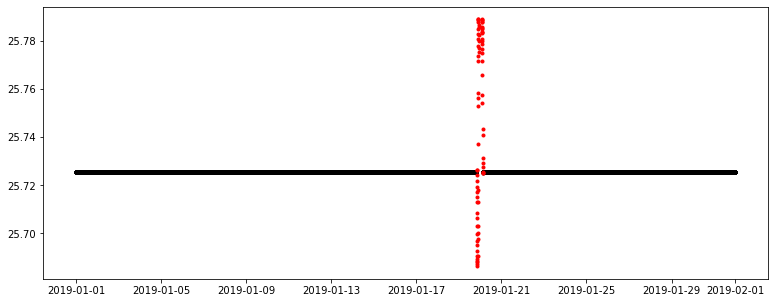

In [10]:
indices = labels == 0
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], 'r.')

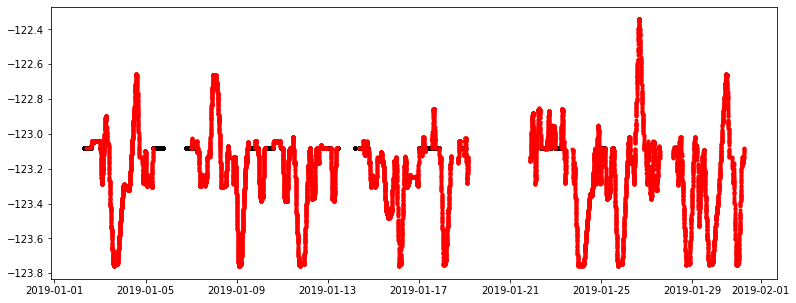

In [102]:
indices = labels == 0

fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(longitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(datetime_objects)[indices], np.array(longitude)[indices], 'r.')

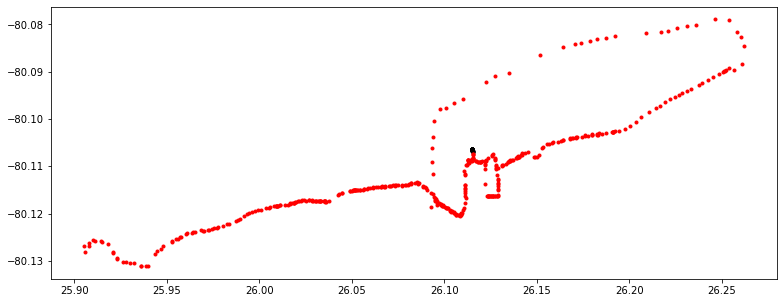

In [324]:
indices = labels == 0
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices], 'r.')

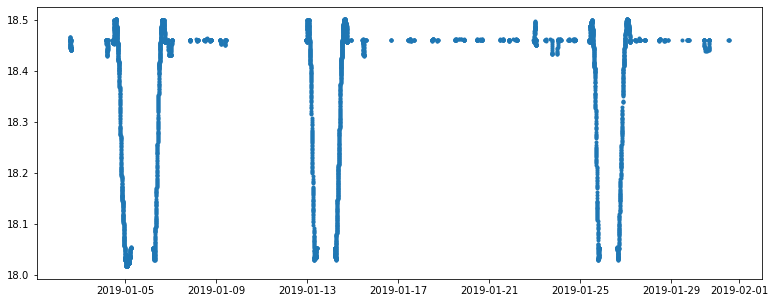

In [240]:
indices = labels == -1
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], '.')

Number of clusters: 27
Number of Noise Points: 4293


In [225]:
len(clustering.components_) + np.sum(labels == -1)

26874

In [226]:
location.shape

(27296, 2)

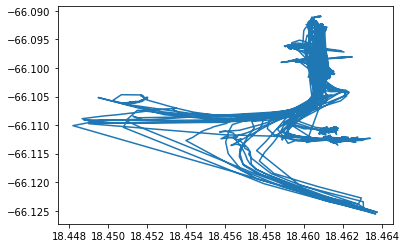

In [163]:
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices])

In [166]:
clustering.core_sample_indices_.shape

(25266,)

In [167]:
location.shape

(27296, 2)

In [127]:
####getting speeds
distance = []
for i in range(1, len(latitude)):
    x = (latitude[i] - latitude[i-1])**2
    y = (longitude[i] - longitude[i-1])**2
    
    distance.append((x+y)**0.5)

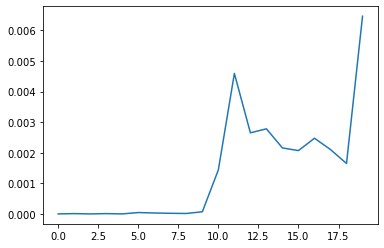

In [131]:
plt.plot(distance[140:160])

In [138]:
dist = np.diff(np.array(distance))

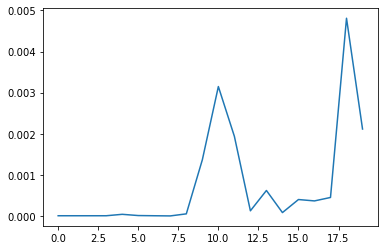

In [140]:
plt.plot(np.abs(dist[140:160]))

In [141]:
dist[140:160]

array([ 1.00000000e-05, -1.00000000e-05,  1.00000000e-05, -1.00000000e-05,
        4.47213595e-05, -1.47213596e-05, -1.00000000e-05, -5.85786438e-06,
        5.58578644e-05,  1.37006944e-03,  3.15062767e-03, -1.94052731e-03,
        1.30279798e-04, -6.24040552e-04, -8.70130050e-05,  4.04083284e-04,
       -3.70695462e-04, -4.54360380e-04,  4.81137527e-03, -2.11817464e-03])

In [122]:
time = []
for i in range(1, len(latitude)):
    time.append((datetime_objects[i] - datetime_objects[i-1]).seconds)

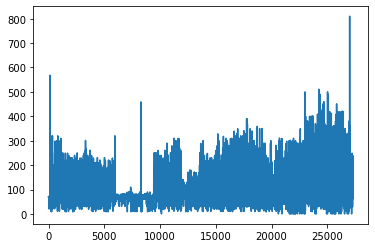

In [123]:
plt.plot(time)

In [126]:
min(time),max(time), np.mean(np.array(time)), np.std(np.array(time))

(0, 810, 93.61263967759663, 45.77165600134406)

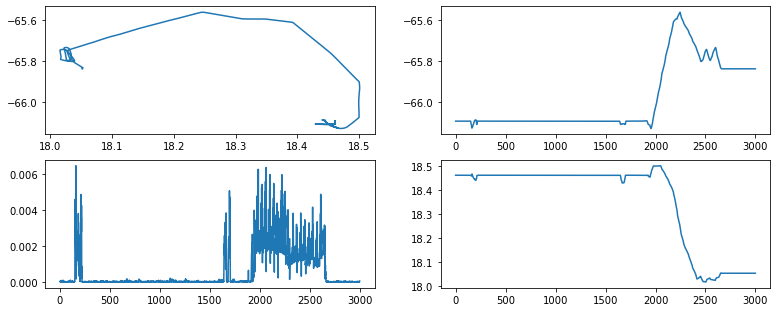

In [192]:
fig = plt.figure(figsize = (13,8))
n = np.arange(0, 3000)

plt.subplot(3, 2, 1)
plt.plot(np.array(latitude)[n], np.array(longitude)[n])

plt.subplot(3, 2, 2)
plt.plot(np.array(longitude)[n])

plt.subplot(3, 2, 3)
plt.plot(np.array(distance)[n])

plt.subplot(3, 2, 4)
plt.plot(np.array(latitude)[n])

#plt.subplot(3, 2, 5)
#plt.plot(np.array(latitude)[n], np.array(longitude)[n], '--')

plt.show()

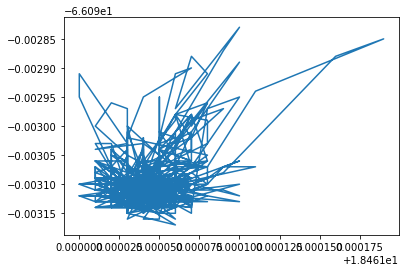

In [187]:
n = np.arange(500, 1500)
plt.plot(np.array(latitude)[n], np.array(longitude)[n])

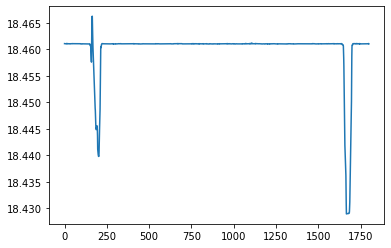

In [184]:
plt.plot(latitude[:n])

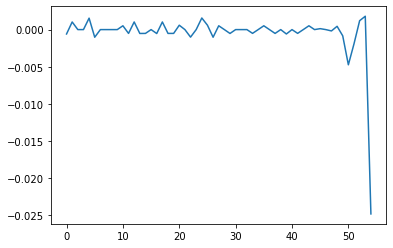

In [121]:
plt.plot(speeds_lat[100:155])

In [78]:
for d in datelist:
    print(d)

2019-01-03T00:26:54
2019-01-06T01:47:56
2019-01-16T19:20:21
2019-01-18T11:36:34
2019-01-19T01:25:48
2019-01-21T12:21:36
2019-01-23T04:07:36
2019-01-25T09:41:41
2019-01-27T02:02:54
2019-01-04T15:33:18
2019-01-06T09:42:44
2019-01-08T16:57:51
2019-01-10T08:47:15
2019-01-26T03:24:47
2019-01-04T17:53:43
2019-01-06T05:19:52
2019-01-07T06:50:45
2019-01-20T13:23:51
2019-01-20T13:38:51
2019-01-08T13:15:51
2019-01-14T04:08:58
2019-01-16T06:31:00
2019-01-20T13:44:52
2019-01-23T05:26:48
2019-01-27T22:04:50
2019-01-31T16:21:26
2019-01-01T18:47:43
2019-01-03T07:51:21
2019-01-12T12:39:12
2019-01-15T20:28:32
2019-01-28T04:47:27
2019-01-16T17:08:21
2019-01-23T00:05:40
2019-01-05T15:01:52
2019-01-12T09:59:45
2019-01-13T07:00:44
2019-01-15T00:53:23
2019-01-15T14:38:11
2019-01-17T23:29:23
2019-01-20T20:43:39
2019-01-21T03:46:54
2019-01-21T04:39:49
2019-01-23T14:38:46
2019-01-24T16:36:18
2019-01-30T22:16:36
2019-01-12T14:50:11
2019-01-15T16:52:33
2019-01-22T07:18:13
2019-01-25T12:11:41
2019-01-26T08:44:49


2019-01-29T09:36:31
2019-01-29T21:34:05
2019-01-31T08:54:26
2019-01-02T22:50:54
2019-01-07T14:38:03
2019-01-12T15:50:07
2019-01-12T11:26:19
2019-01-13T03:11:48
2019-01-14T08:22:53
2019-01-22T04:51:12
2019-01-25T21:42:06
2019-01-25T21:05:36
2019-01-27T22:07:18
2019-01-31T10:36:26
2019-01-31T03:42:29
2019-01-10T04:15:28
2019-01-11T04:32:23
2019-01-19T21:41:34
2019-01-20T20:55:38
2019-01-22T03:15:14
2019-01-25T06:35:41
2019-01-25T07:35:41
2019-01-31T18:45:26
2019-01-03T05:09:20
2019-01-16T10:09:58
2019-01-16T18:53:22
2019-01-26T21:06:33
2019-01-29T16:32:51
2019-01-02T09:37:03
2019-01-02T06:25:03
2019-01-03T02:36:23
2019-01-05T08:40:12
2019-01-09T00:57:28
2019-01-11T17:50:15
2019-01-22T14:53:10
2019-01-26T11:38:48
2019-01-31T00:24:33
2019-01-06T20:51:52
2019-01-07T17:46:34
2019-01-13T01:42:28
2019-01-16T18:50:24
2019-01-20T10:28:42
2019-01-21T14:00:33
2019-01-25T12:32:43
2019-01-30T20:59:41
2019-01-07T13:53:03
2019-01-07T23:34:27
2019-01-13T15:42:31
2019-01-21T14:05:00
2019-01-23T09:29:46


2019-01-16T17:29:21
2019-01-16T16:08:22
2019-01-23T10:35:44
2019-01-26T17:46:29
2019-01-03T08:40:16
2019-01-07T09:29:08
2019-01-11T07:02:15
2019-01-15T06:35:23
2019-01-18T05:26:38
2019-01-18T08:57:34
2019-01-23T16:00:11
2019-01-01T08:29:18
2019-01-06T04:46:51
2019-01-07T03:50:51
2019-01-08T23:24:29
2019-01-08T04:01:12
2019-01-03T13:17:11
2019-01-04T07:33:00
2019-01-07T05:02:46
2019-01-15T07:32:26
2019-01-19T05:34:47
2019-01-21T01:21:20
2019-01-31T02:03:29
2019-01-03T17:29:11
2019-01-09T10:37:23
2019-01-10T10:02:15
2019-01-11T20:20:15
2019-01-13T00:51:27
2019-01-14T00:18:21
2019-01-21T09:28:38
2019-01-22T16:04:06
2019-01-24T09:18:29
2019-01-25T16:59:57
2019-01-01T18:59:42
2019-01-06T01:20:36
2019-01-10T19:20:21
2019-01-14T16:20:25
2019-01-16T10:53:55
2019-01-31T10:42:26
2019-01-10T17:04:29
2019-01-13T10:41:10
2019-01-18T08:24:35
2019-01-19T00:19:52
2019-01-25T18:16:22
2019-01-28T12:39:09
2019-01-08T08:16:34
2019-01-17T06:48:50
2019-01-22T19:49:49
2019-01-22T13:45:14
2019-01-24T05:44:11


2019-01-15T18:25:33
2019-01-22T01:39:12
2019-01-28T08:27:08
2019-01-30T12:16:19
2019-01-31T05:30:27
2019-01-31T13:15:25
2019-01-31T04:30:25
2019-01-01T09:23:18
2019-01-03T06:00:22
2019-01-08T05:55:12
2019-01-14T08:10:53
2019-01-15T06:29:25
2019-01-16T06:21:58
2019-01-18T23:07:51
2019-01-23T10:05:44
2019-01-24T13:12:21
2019-01-28T01:05:52
2019-01-06T12:15:42
2019-01-24T21:31:38
2019-01-27T03:59:44
2019-01-07T16:31:32
2019-01-12T10:13:36
2019-01-14T09:52:35
2019-01-15T00:47:23
2019-01-19T07:16:47
2019-01-19T07:28:46
2019-01-25T04:35:12
2019-01-27T21:31:50
2019-01-05T06:25:46
2019-01-19T16:01:37
2019-01-20T23:12:24
2019-01-27T05:38:46
2019-01-29T03:36:13
2019-01-05T08:31:13
2019-01-06T23:38:45
2019-01-10T08:41:16
2019-01-16T12:20:55
2019-01-17T01:27:17
2019-01-19T13:49:37
2019-01-24T17:06:18
2019-01-28T17:34:43
2019-01-29T00:03:13
2019-01-30T08:37:19
2019-01-05T22:01:44
2019-01-07T20:10:26
2019-01-10T08:14:15
2019-01-14T13:56:26
2019-01-18T17:32:07
2019-01-20T02:16:04
2019-01-23T20:44:36


2019-01-01T22:10:44
2019-01-06T05:31:17
2019-01-10T22:25:13
2019-01-12T11:18:54
2019-01-14T23:38:24
2019-01-17T09:18:47
2019-01-21T18:27:14
2019-01-26T13:38:34
2019-01-05T08:43:38
2019-01-10T13:26:20
2019-01-10T02:12:30
2019-01-14T19:23:27
2019-01-14T07:45:24
2019-01-30T08:31:19
2019-01-02T09:55:04
2019-01-05T09:54:56
2019-01-05T23:22:43
2019-01-06T07:12:42
2019-01-10T03:36:30
2019-01-10T18:58:26
2019-01-10T01:57:28
2019-01-14T08:25:20
2019-01-16T15:14:21
2019-01-27T05:29:44
2019-01-13T05:24:42
2019-01-14T06:17:57
2019-01-17T05:30:15
2019-01-23T17:26:36
2019-01-27T06:53:45
2019-01-28T13:27:08
2019-01-31T17:57:25
2019-01-09T17:30:02
2019-01-10T12:11:03
2019-01-12T05:49:55
2019-01-15T14:50:11
2019-01-20T04:19:04
2019-01-26T20:55:36
2019-01-10T16:46:31
2019-01-13T05:00:42
2019-01-17T20:23:24
2019-01-19T16:40:37
2019-01-21T11:36:33
2019-01-22T08:51:13
2019-01-26T20:58:06
2019-01-30T11:46:20
2019-01-08T22:21:31
2019-01-24T00:55:48
2019-01-31T04:21:26
2019-01-16T07:48:58
2019-01-19T04:52:47


2019-01-21T20:48:14
2019-01-27T15:40:29
2019-01-27T23:10:14
2019-01-04T21:39:30
2019-01-05T10:37:52
2019-01-06T22:34:20
2019-01-06T08:27:42
2019-01-11T23:08:28
2019-01-17T10:27:47
2019-01-19T16:37:36
2019-01-06T01:04:09
2019-01-08T11:50:31
2019-01-09T16:16:18
2019-01-12T13:25:58
2019-01-17T08:03:48
2019-01-22T13:00:12
2019-01-27T05:26:45
2019-01-28T08:54:09
2019-01-05T08:22:43
2019-01-10T15:37:29
2019-01-10T23:44:31
2019-01-17T17:30:58
2019-01-17T20:53:24
2019-01-31T18:12:26
2019-01-05T10:12:56
2019-01-11T18:20:15
2019-01-22T04:36:13
2019-01-29T08:08:09
2019-01-29T22:25:09
2019-01-30T14:37:15
2019-01-31T15:15:27
2019-01-06T09:39:43
2019-01-14T19:02:26
2019-01-18T03:47:40
2019-01-21T06:49:44
2019-01-28T19:33:14
2019-01-31T04:24:25
2019-01-04T19:11:07
2019-01-05T21:55:47
2019-01-19T21:27:13
2019-01-23T01:05:42
2019-01-26T13:08:47
2019-01-27T00:56:00
2019-01-31T14:12:26
2019-01-10T04:30:18
2019-01-14T20:56:24
2019-01-21T15:09:25
2019-01-22T01:36:13
2019-01-23T20:38:37
2019-01-25T08:59:41


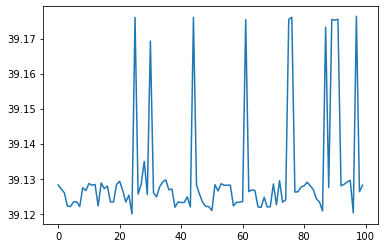

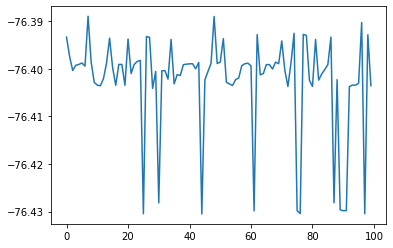

In [63]:
plt.plot(longitude[:100])

In [29]:
datelist[0],datelist[-1] 

('2019-01-01T00:00:06', '2019-01-31T23:59:26')

Help on DataFrame in module pyspark.sql.dataframe object:

class DataFrame(builtins.object)
 |  DataFrame(jdf, sql_ctx)
 |  
 |  A distributed collection of data grouped into named columns.
 |  
 |  A :class:`DataFrame` is equivalent to a relational table in Spark SQL,
 |  and can be created using various functions in :class:`SparkSession`::
 |  
 |      people = spark.read.parquet("...")
 |  
 |  Once created, it can be manipulated using the various domain-specific-language
 |  (DSL) functions defined in: :class:`DataFrame`, :class:`Column`.
 |  
 |  To select a column from the data frame, use the apply method::
 |  
 |      ageCol = people.age
 |  
 |  A more concrete example::
 |  
 |      # To create DataFrame using SparkSession
 |      people = spark.read.parquet("...")
 |      department = spark.read.parquet("...")
 |  
 |      people.filter(people.age > 30).join(department, people.deptId == department.id) \
 |        .groupBy(department.name, "gender").agg({"salary": "avg", "age